# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from functions.khi_2 import cramers_v
from scipy.special import inv_boxcox

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

## Load Data

In [2]:
df_2015=pd.read_csv('./data/2015-building-energy-benchmarking.csv')
df_2016=pd.read_csv('./data/2016-building-energy-benchmarking.csv')

Le fait d'avoir deux datasets est embetant -> je vais essayer de les concatener sans perdre de la data

## Columns analysis

Analyse des colonnes pour pouvoir concat les deux datasets

In [3]:
len(df_2015.columns)==len(df_2016.columns)

False

In [4]:
col_2015=[]
for column in list(df_2015.columns):
    if column not in (df_2016.columns):
        col_2015.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2015]

colonnes de 2015 non présente dans 2016 : 
- Location
- OtherFuelUse(kBtu)
- GHGEmissions(MetricTonsCO2e)
- GHGEmissionsIntensity(kgCO2e/ft2)
- Comment
- 2010 Census Tracts
- Seattle Police Department Micro Community Policing Plan Areas
- City Council Districts
- SPD Beats
- Zip Codes


[None, None, None, None, None, None, None, None, None, None]

In [5]:
col_2016=[]
for column in list(df_2016.columns):
    if column not in (df_2015.columns):
        col_2016.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2016]

colonnes de 2015 non présente dans 2016 : 
- Address
- City
- State
- ZipCode
- Latitude
- Longitude
- Comments
- TotalGHGEmissions
- GHGEmissionsIntensity


[None, None, None, None, None, None, None, None, None]

<AxesSubplot:xlabel='variable', ylabel='value'>

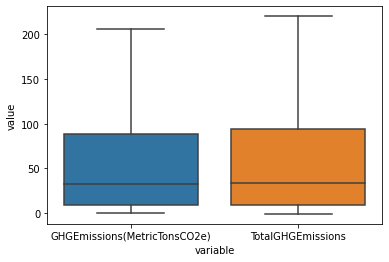

In [6]:
concat_data_1 =pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2016['TotalGHGEmissions']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_1), showfliers=False)

In [7]:
#seems the same

<AxesSubplot:xlabel='variable', ylabel='value'>

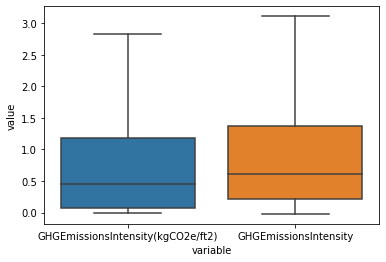

In [8]:
concat_data_2 =pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['GHGEmissionsIntensity']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_2), showfliers=False)

In [9]:
#seems the same

In [10]:
df_2015['OtherFuelUse(kBtu)'].value_counts()

0.0          3313
6464408.0       1
178094.0        1
143134.0        1
5596.0          1
229942.0        1
145944.0        1
427938.0        1
1943011.0       1
12551.0         1
547.0           1
15527.0         1
2304567.0       1
2944419.0       1
337952.0        1
8269669.0       1
177849.0        1
182715.0        1
Name: OtherFuelUse(kBtu), dtype: int64

__Todo :__\
__2015__ 
 - Location : extract data [latitude and longitude, adress, ...]
 - comment/comments ->rename
 - GHGEmissions(MetricTonsCO2e) <->TotalGHGEmissions au vue de la data -> rename
 - 'GHGEmissionsIntensity(kgCO2e/ft2)' <-> 'GHGEmissionsIntensity' -> rename
 - OtherFuelUse(kBtu) : peu d'info -> drop
 - Seattle Police Department Micro Community Policing Plan Areas -> semble non relié à notre probleme -> drop
 - City Council Districts : idem -> drop
 - SPD Beats : semble être des problématique police -> drop
 - Zip Codes : je sais ap ce que c'est -> drop


## Data engeeniring for concat

### deal with Location column

In [11]:
# eval - > permet d'eviter d'avoir un format pourri
df_2015['Location'] = [eval(str(item)) for index, item in df_2015.Location.iteritems()]

In [12]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['City'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['city'])
df_2015['State'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['state'])
df_2015['ZipCode'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['zip'])

### Deal with renaming + drop

In [13]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
                       'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
                       'Comment':'Comments'},
              inplace=True)

In [14]:
df_2015.drop(columns=['OtherFuelUse(kBtu)',
                      'Seattle Police Department Micro Community Policing Plan Areas', 
                      'City Council Districts',
                      'SPD Beats',
                      'Zip Codes',
                      'Location'],
            inplace=True)

### Concat Df 🍾

In [15]:
list(df_2015.columns).sort() == list(df_2016.columns).sort()

True

In [16]:
df = pd.concat([df_2015, df_2016], axis=0)

In [17]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts', 

# Data Explo

__Definitions :__
- __GFA__ = Gross Floor Area : is the total property square footage, as measured between the exterior walls of the building(s)

In [18]:
# REMOVE residential building !
df=df[~df.BuildingType.isin(['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'])]
df.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   BuildingType                     3318 non-null   object 
 3   PrimaryPropertyType              3318 non-null   object 
 4   PropertyName                     3318 non-null   object 
 5   TaxParcelIdentificationNumber    3317 non-null   object 
 6   CouncilDistrictCode              3318 non-null   int64  
 7   Neighborhood                     3318 non-null   object 
 8   YearBuilt                        3318 non-null   int64  
 9   NumberofBuildings                3316 non-null   float64
 10  NumberofFloors                   3310 non-null   float64
 11  PropertyGFATotal                 3318 non-null   int64  
 12  PropertyGFAParking  

In [20]:
cat_columns=[]
numeric_columns=[]
for column in list(df.columns):
    if df[column].dtype=='object' :
        cat_columns.append(column)
    else :
        numeric_columns.append(column)

In [21]:
df.select_dtypes('float').columns

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', '2010 Census Tracts'],
      dtype='object')

## Numeric columns

### premiere analyse

In [22]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   CouncilDistrictCode              3318 non-null   int64  
 3   YearBuilt                        3318 non-null   int64  
 4   NumberofBuildings                3316 non-null   float64
 5   NumberofFloors                   3310 non-null   float64
 6   PropertyGFATotal                 3318 non-null   int64  
 7   PropertyGFAParking               3318 non-null   int64  
 8   PropertyGFABuilding(s)           3318 non-null   int64  
 9   LargestPropertyUseTypeGFA        3247 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  1667 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   684 non-null    float64
 12  ENERGYSTARScore     

OSEBuildingID


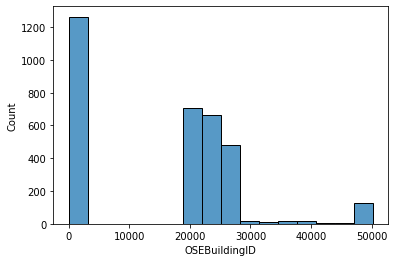

DataYear
2016    1668
2015    1650
Name: DataYear, dtype: int64


CouncilDistrictCode
7    1062
2     791
3     404
4     332
5     264
1     236
6     229
Name: CouncilDistrictCode, dtype: int64


YearBuilt


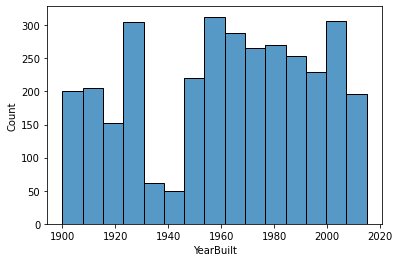

NumberofBuildings


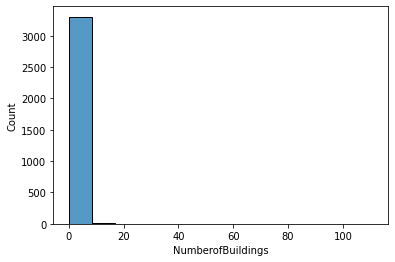

NumberofFloors


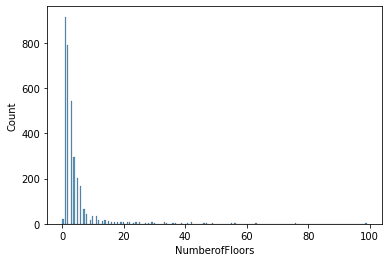

PropertyGFATotal


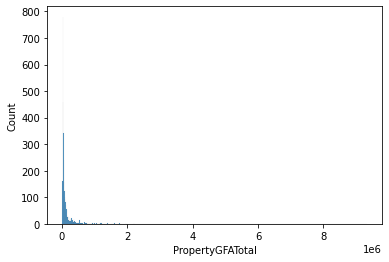

PropertyGFAParking


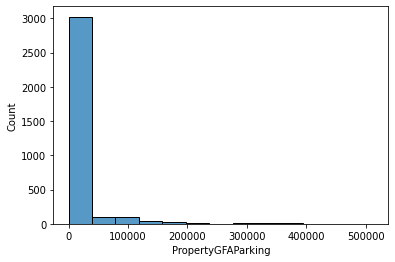

PropertyGFABuilding(s)


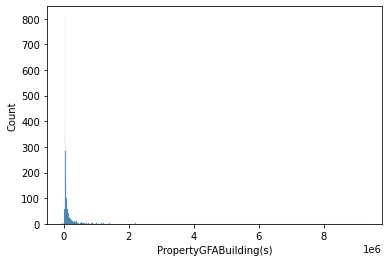

LargestPropertyUseTypeGFA


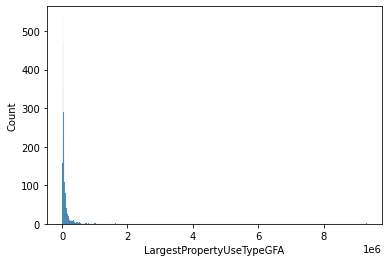

SecondLargestPropertyUseTypeGFA


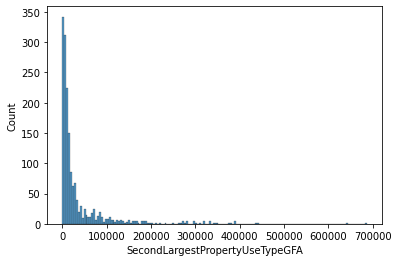

ThirdLargestPropertyUseTypeGFA


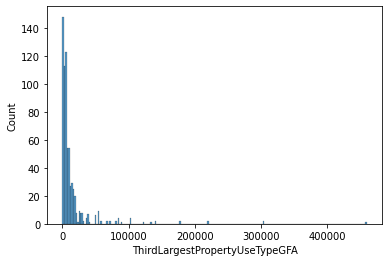

ENERGYSTARScore


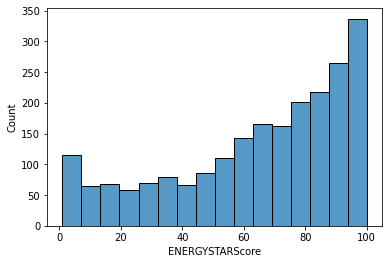

SiteEUI(kBtu/sf)


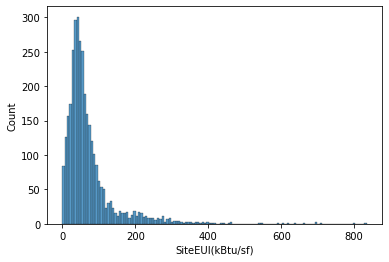

SiteEUIWN(kBtu/sf)


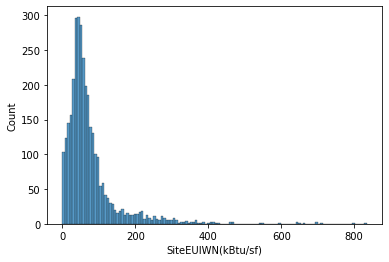

SourceEUI(kBtu/sf)


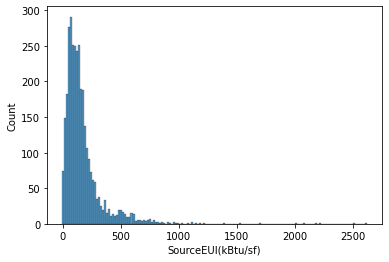

SourceEUIWN(kBtu/sf)


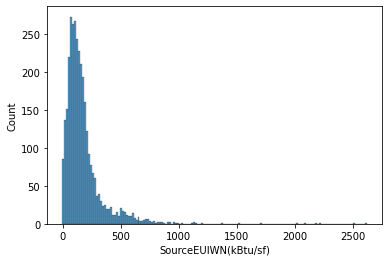

SiteEnergyUse(kBtu)


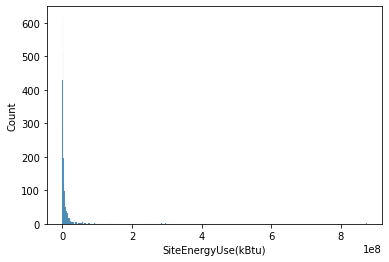

SiteEnergyUseWN(kBtu)


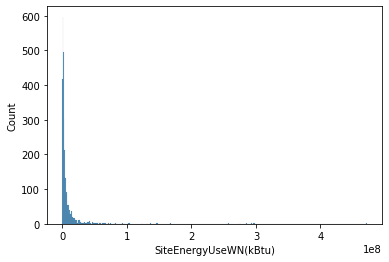

SteamUse(kBtu)


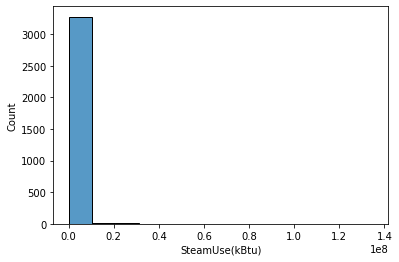

Electricity(kWh)


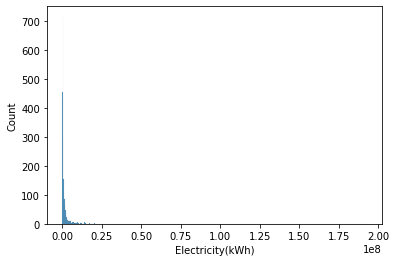

Electricity(kBtu)


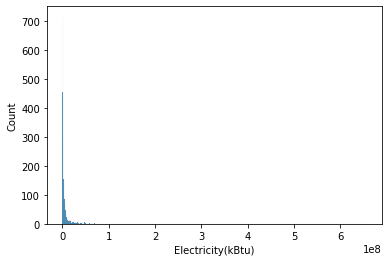

NaturalGas(therms)


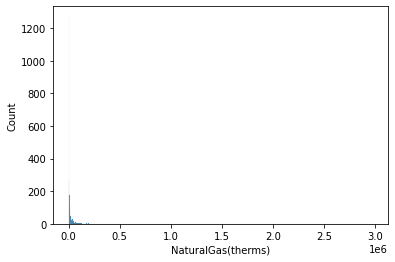

NaturalGas(kBtu)


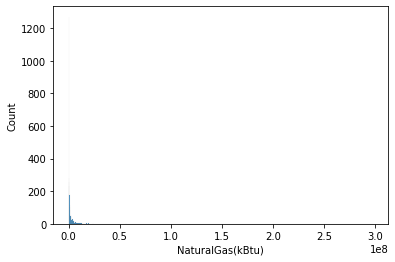

TotalGHGEmissions


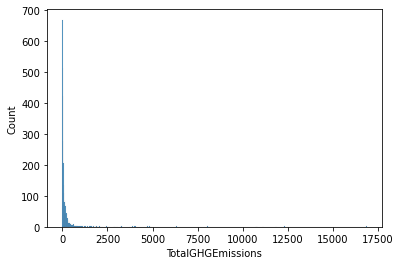

GHGEmissionsIntensity


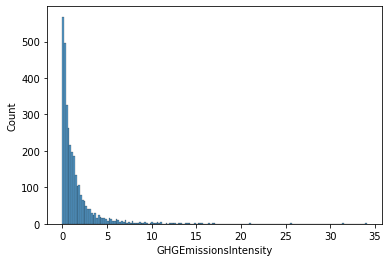

2010 Census Tracts


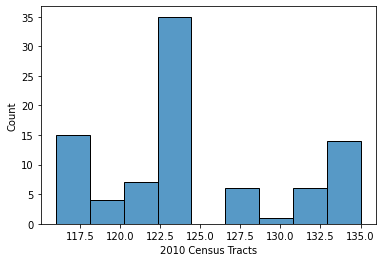

In [23]:
for column in numeric_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print('\n')
    else :
        print(column)
        sns.histplot(df[column])
        plt.show()

In [24]:
numeric_columns

['OSEBuildingID',
 'DataYear',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '2010 Census Tracts']

<AxesSubplot:>

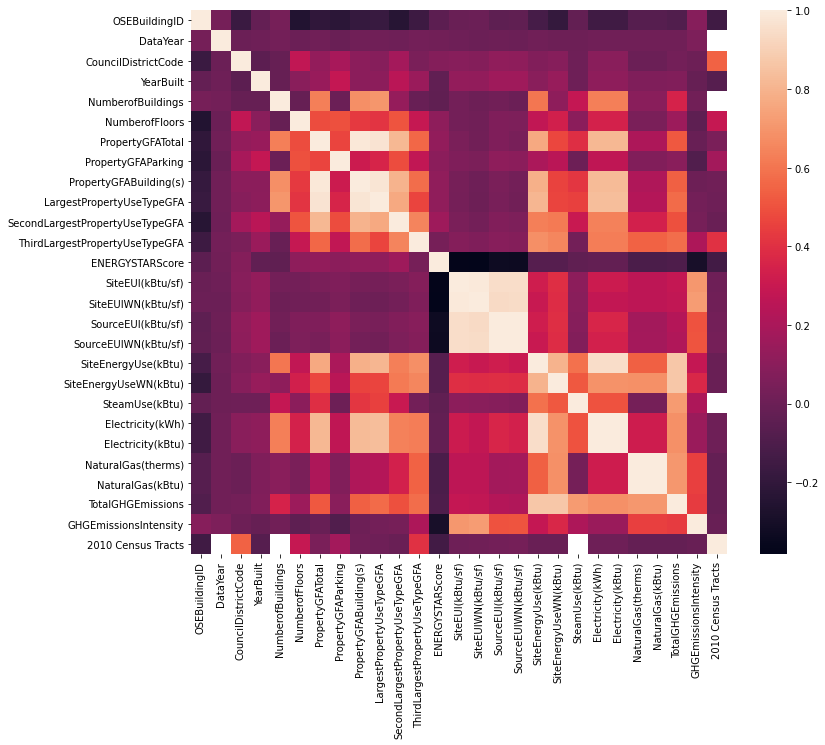

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr())

In [26]:
corr = df.corr()
corr.style.background_gradient(cmap='Greens').set_precision(3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_74808/2921387194.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='Greens').set_precision(3)


colonne contenant WN:
- "Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot." -> semble peut pertinant à premiere vue 


In [27]:
numeric_to_drop=[
    'SiteEnergyUseWN(kBtu)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)', #je garde en kwh
    'NaturalGas(therms)',
    '2010 Census Tracts',#trop d'outliers
    'LargestPropertyUseTypeGFA',# a voir
    'SecondLargestPropertyUseTypeGFA',#a voir
    'ThirdLargestPropertyUseTypeGFA',#a voir
    'SiteEUI(kBtu/sf)', # pour la problématique je suprime ces données dépendantes de la surface
    'SourceEUI(kBtu/sf)',# pour la problématique je suprime ces données dépendantes de la surface
    'GHGEmissionsIntensity',# pour la problématique je suprime ces données dépendantes de la surface
    'SteamUse(kBtu)', #à éviter car provient de relevé
    'Electricity(kBtu)', #à éviter car provient de relevé
    'NaturalGas(kBtu)', #à éviter car provient de relevé
    
    ]
#'PropertyGFATotal' #du à la corrélation avec PropertyGFPrking /Building(s)

In [28]:
df.drop(columns=numeric_to_drop, inplace=True)

In [29]:
numeric_columns = [i for i in numeric_columns if i not in numeric_to_drop]

### Check outliers

In [30]:
df[numeric_columns].describe()

OSEBuildingID     DataYear  CouncilDistrictCode    YearBuilt  \
count    3318.000000  3318.000000          3318.000000  3318.000000   
mean    15951.816154  2015.502712             4.365883  1961.536769   
std     13411.897096     0.500068             2.195304    32.709772   
min         1.000000  2015.000000             1.000000  1900.000000   
25%       579.000000  2015.000000             2.000000  1930.000000   
50%     21122.000000  2016.000000             4.000000  1965.000000   
75%     24556.750000  2016.000000             7.000000  1989.000000   
max     50226.000000  2016.000000             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        3316.000000     3310.000000      3.318000e+03   
mean            1.117310        4.126888      1.156672e+05   
std             2.219845        6.567333      2.511222e+05   
min             0.000000        0.000000      1.128500e+04   
25%             1.000000        1.000000      2.951225e+04   
50%             1.000000        2.000000      4.924600e+04   
75%             1.000000        4.000000      1.047860e+05   
max           111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  ENERGYSTARScore  \
count         3318.000000            3.318000e+03      2211.000000   
mean         13303.304702            1.023639e+05        64.815920   
std          43596.620504            2.340749e+05        28.549886   
min             -2.000000           -5.055000e+04         1.000000   
25%              0.000000            2.850775e+04        47.000000   
50%              0.000000            4.736800e+04        72.000000   
75%              0.000000            9.447150e+04        89.000000   
max         512608.000000            9.320156e+06       100.000000   

       SiteEnergyUse(kBtu)  TotalGHGEmissions  
count         3.309000e+03        3309.000000  
mean          8.068625e+06         177.038779  
std           2.525462e+07         666.442480  
min           0.000000e+00          -0.800000  
25%           1.223425e+06          19.720000  
50%           2.505271e+06          49.160000  
75%           6.917280e+06         138.870000  
max           8.739237e+08       16870.980000

__Pour remplir les données manquantes des étages/nombres de batiments :__
- remplir par la vaeur associé à l'id du batiment de l'autre année
- par défaut : par 0
- puis remplacer 0 par 1.. *-> à voir implémentation méthode par la moyenne des batiements de la même catégorie ?*

In [31]:
#NumberofBuildings
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df.groupby('OSEBuildingID')['NumberofBuildings'].transform('max'))
df['NumberofBuildings']=df['NumberofBuildings'].fillna(0)
df['NumberofBuildings'] = df['NumberofBuildings'].replace(0.0, 1.0)
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [32]:
#NumberofFloors cant be 0 floors + deal with outliers
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('OSEBuildingID')['NumberofFloors'].transform('max'))
df['NumberofFloors'] = df['NumberofFloors'].replace(0.0, 1.0)

In [33]:
df['NumberofFloors'].value_counts()

1.0     943
2.0     789
3.0     541
4.0     295
5.0     202
6.0     167
7.0      67
8.0      43
11.0     36
10.0     35
14.0     17
12.0     16
9.0      16
15.0     13
13.0     13
19.0     10
42.0     10
17.0      8
29.0      6
21.0      6
22.0      6
16.0      6
20.0      6
24.0      6
33.0      6
25.0      6
18.0      6
23.0      5
34.0      4
36.0      4
41.0      4
46.0      2
99.0      2
76.0      2
27.0      2
56.0      2
30.0      2
63.0      2
55.0      2
37.0      2
49.0      2
28.0      2
47.0      2
39.0      2
Name: NumberofFloors, dtype: int64

In [34]:
#PropertyGFAParking
df['PropertyGFAParking']=df['PropertyGFAParking'].replace(-2.0, 0.0)
df['PropertyGFAParking'].min()

0

In [35]:
# PropertyGFABuilding(s)
property_gfa_building_neg = list(df[(df['PropertyGFABuilding(s)']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']<0)]['PropertyGFABuilding(s)'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']>0)]['PropertyGFABuilding(s)'].item()
    df['PropertyGFABuilding(s)']=df['PropertyGFABuilding(s)'].replace(to_replace, value)

In [36]:
df['PropertyGFABuilding(s)'].min()

3636

In [37]:
#PropertyGFA total
property_gfa_building_neg = list(df[(df['PropertyGFATotal']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFATotal']<0)]['PropertyGFATotal'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFATotal']>0)]['PropertyGFATotal'].item()
    df['PropertyGFATotal']=df['PropertyGFATotal'].replace(to_replace, value)

In [38]:
# calcul ratio parking/surface totale
df['parking_ratio']=df['PropertyGFAParking']/df['PropertyGFATotal']*100
df['building_ratio']=df['PropertyGFABuilding(s)']/df['PropertyGFATotal']*100

In [39]:
df[df.parking_ratio>80]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3139          29788      2015  NonResidential  Small- and Mid-Sized Office   
3322          50002      2015  NonResidential                        Other   
1109          20885      2016  NonResidential        Senior Care Community   

                        PropertyName TaxParcelIdentificationNumber  \
3139   QUEEN ANNE SQUARE WEST (2013)                    7015350000   
3322  FREEWAY MOTORS UNIVERSITY AUDI                    6746701515   
1109                  Ballard Center                    1865400030   

      CouncilDistrictCode           Neighborhood  YearBuilt  \
3139                    7  MAGNOLIA / QUEEN ANNE       1982   
3322                    4              NORTHEAST       2014   
1109                    6                BALLARD       1966   

      NumberofBuildings  ...  ComplianceStatus  Outlier     Latitude  \
3139                1.0  ...         Compliant      NaN  47.62496806   
3322                1.0  ...         Compliant      NaN  47.66411096   
1109                1.0  ...         Compliant      NaN     47.69875   

         Longitude     City State  ZipCode             Address parking_ratio  \
3139   -122.359705  SEATTLE    WA    98119                 NaN    180.181431   
3322  -122.3166394  SEATTLE    WA    98105                 NaN    250.231812   
1109    -122.36725  Seattle    WA  98117.0  820 NW 95th Street     89.502252   

      building_ratio  
3139      100.000000  
3322      100.000000  
1109       10.497748  

[3 rows x 34 columns]

In [40]:
df[df.OSEBuildingID==20885][['DataYear','PropertyGFAParking', 'PropertyGFABuilding(s)', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)']]

DataYear  PropertyGFAParking  PropertyGFABuilding(s)  PropertyGFATotal  \
1122      2015                   0                   60422             60422   
1109      2016               31000                    3636             34636   

      SiteEnergyUse(kBtu)  
1122           10420096.0  
1109           12148720.0

In [41]:
df.loc[3139, 'PropertyGFAParking']=0
df.loc[3322, 'PropertyGFAParking']=0
df.drop(1109, inplace=True)

In [42]:
df['parking_ratio']=df['PropertyGFAParking']/df['PropertyGFATotal']*100

In [43]:
df[['parking_ratio', 'building_ratio', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking']].corr()

parking_ratio  building_ratio  PropertyGFATotal  \
parking_ratio                1.000000       -1.000000          0.178742   
building_ratio              -1.000000        1.000000         -0.178742   
PropertyGFATotal             0.178742       -0.178742          1.000000   
PropertyGFABuilding(s)       0.067170       -0.067170          0.986346   
PropertyGFAParking           0.669697       -0.669697          0.465445   

                        PropertyGFABuilding(s)  PropertyGFAParking  
parking_ratio                         0.067170            0.669697  
building_ratio                       -0.067170           -0.669697  
PropertyGFATotal                      0.986346            0.465445  
PropertyGFABuilding(s)                1.000000            0.313329  
PropertyGFAParking                    0.313329            1.000000

In [44]:
df.drop(columns=['PropertyGFATotal', 'PropertyGFAParking'], inplace=True)
numeric_columns=[i for i in numeric_columns if i not in numeric_to_drop if numeric_columns not in [
    'PropertyGFATotal', 'PropertyGFAParking']]
numeric_columns.append('parking_ratio')
numeric_columns.append('building_ratio')

## Cat Columns

In [45]:
for column in cat_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print(f"{len(df[df[column].isna()])} valeurs manquantes'")
        print('\n')
    else :
        print(f'la colonne {column} contient {len(df[column].value_counts())} valeurs différentes et {len(df[df[column].isna()])} valeurs manquantes')
        print('\n')
    

BuildingType
NonResidential        2919
SPS-District K-12      197
Nonresidential COS     153
Campus                  46
Nonresidential WA        1
Name: BuildingType, dtype: int64
0 valeurs manquantes'


la colonne PrimaryPropertyType contient 30 valeurs différentes et 0 valeurs manquantes


la colonne PropertyName contient 3202 valeurs différentes et 0 valeurs manquantes


la colonne TaxParcelIdentificationNumber contient 1835 valeurs différentes et 1 valeurs manquantes


la colonne Neighborhood contient 19 valeurs différentes et 0 valeurs manquantes


la colonne ListOfAllPropertyUseTypes contient 387 valeurs différentes et 63 valeurs manquantes


la colonne LargestPropertyUseType contient 57 valeurs différentes et 71 valeurs manquantes


la colonne SecondLargestPropertyUseType contient 47 valeurs différentes et 1651 valeurs manquantes


la colonne ThirdLargestPropertyUseType contient 40 valeurs différentes et 2633 valeurs manquantes


la colonne YearsENERGYSTARCertified contient 113

In [46]:
#BuildingType
df['BuildingType']=df['BuildingType'].replace('Nonresidential COS', 'NonResidential')
df['BuildingType']=df['BuildingType'].replace('Nonresidential WA', 'NonResidential')
df['BuildingType'].value_counts()

NonResidential       3073
SPS-District K-12     197
Campus                 46
Name: BuildingType, dtype: int64

In [47]:
df.groupby(['BuildingType'], as_index=False).mean()[['BuildingType','SiteEnergyUse(kBtu)']]

BuildingType  SiteEnergyUse(kBtu)
0             Campus         5.907564e+07
1     NonResidential         7.597814e+06
2  SPS-District K-12         3.347582e+06

In [48]:
len(df.PrimaryPropertyType.unique())

30

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

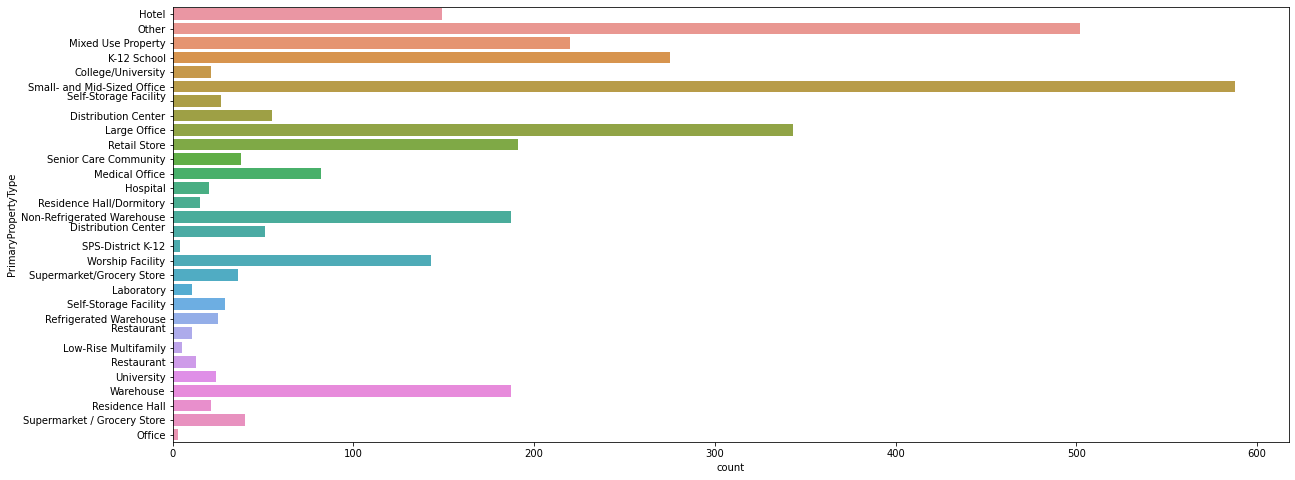

In [49]:
#PrimaryPropertyType
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [50]:
test = df[['PrimaryPropertyType', 'OSEBuildingID']]
dfg=test.groupby(['OSEBuildingID']).agg(set).reset_index()
dfg['taille'] = dfg['PrimaryPropertyType'].apply(lambda x : len(x))
list(dfg[dfg['taille']>1]['PrimaryPropertyType'])

[{'College/University', 'University'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Distribution Center', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Other', 'Retail Store'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'College/University', 'University'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Distribution Center', 'Distribution Center\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'K-12 School', 'SPS-District K-12'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Mixed Use Property', 'Other'},
 {'Non-Refrigerated 

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

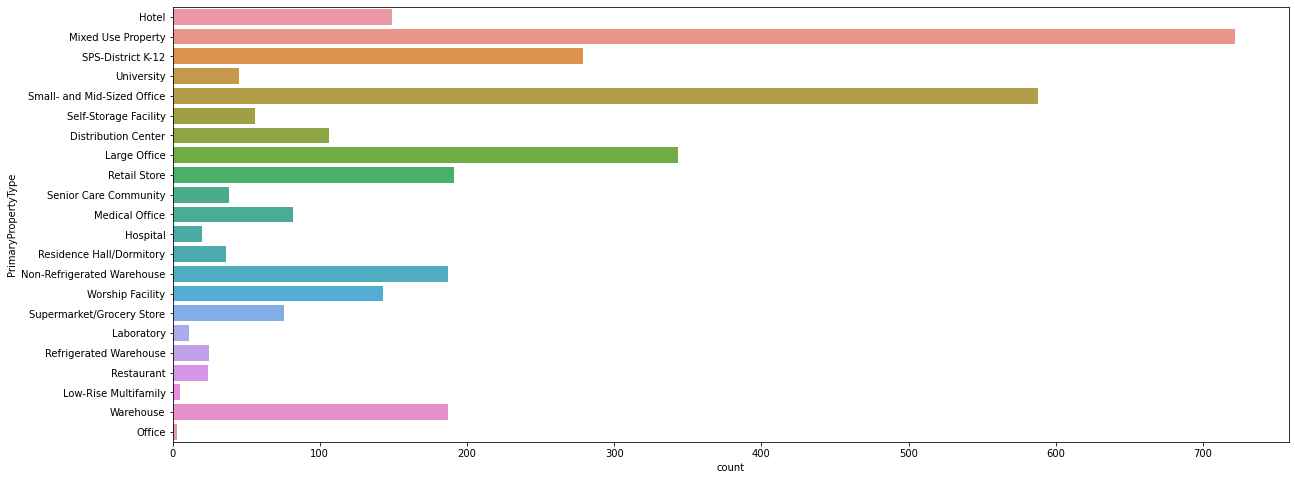

In [51]:
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('College/University', 'University')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility\n', 'Self-Storage Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Distribution Center\n', 'Distribution Center')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Residence Hall', 'Residence Hall/Dormitory')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('K-12 School', 'SPS-District K-12')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Supermarket / Grocery Store', \
                                                            'Supermarket/Grocery Store')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Other', \
                                                            'Mixed Use Property')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [52]:
# check des distributions par primary property type
# j'enleve les low rise/mid rise multifamily car données trop nombereuses + outliers qui écrase distribution
def fill_mean(row):
    mean = df_mean[df_mean['PrimaryPropertyType']==row]['SiteEnergyUse(kBtu)'].item()
    return mean
df_test = df.copy()
df_test = df_test[df_test['SiteEnergyUse(kBtu)']<80000000]
df_mean = df_test.groupby(['PrimaryPropertyType'], as_index=False).mean()[['PrimaryPropertyType','SiteEnergyUse(kBtu)']]
df_test['mean_cat'] = df_test['PrimaryPropertyType'].apply(fill_mean)
df_test
df_test=df_test.sort_values(by=['mean_cat'])

<AxesSubplot:ylabel='SiteEnergyUse(kBtu)'>

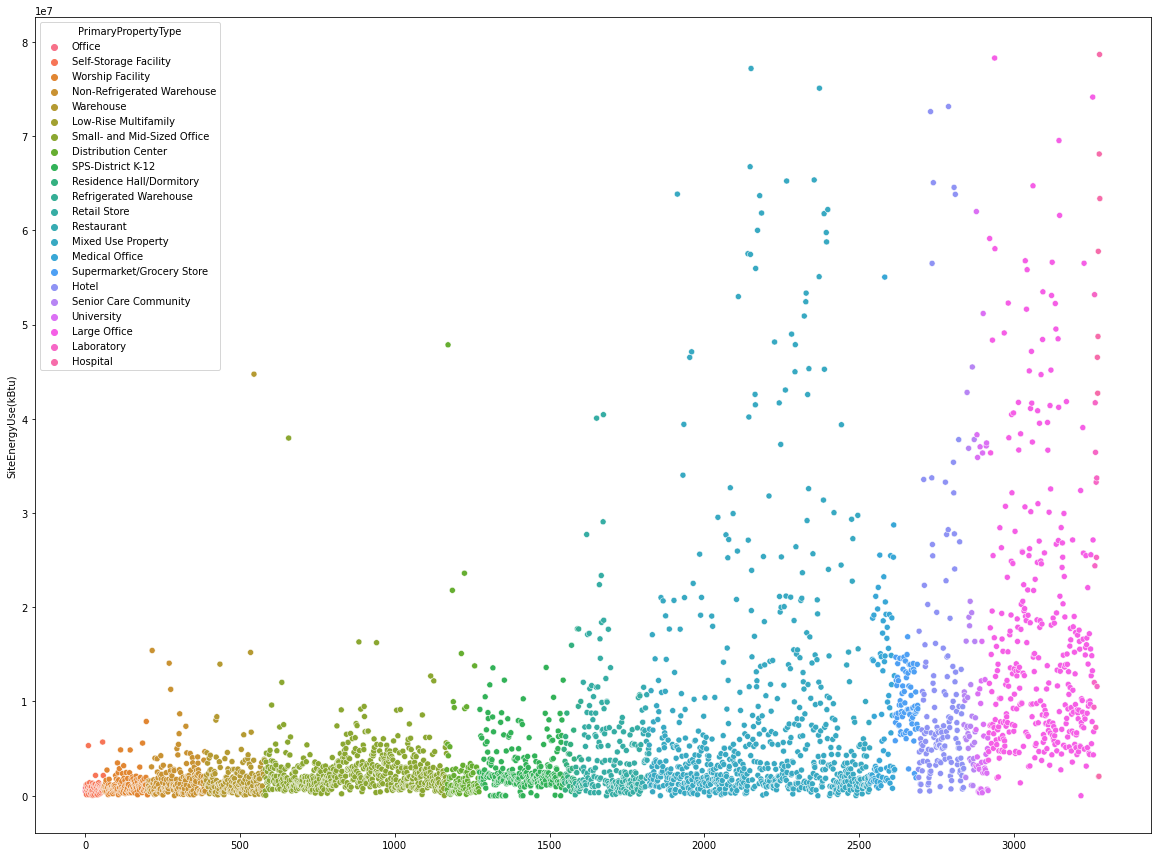

In [53]:
plt.figure(figsize=(20,15))
sns.scatterplot(y=df_test['SiteEnergyUse(kBtu)'], x=[i for i in range(len(df_test))], hue=df_test['PrimaryPropertyType'])


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

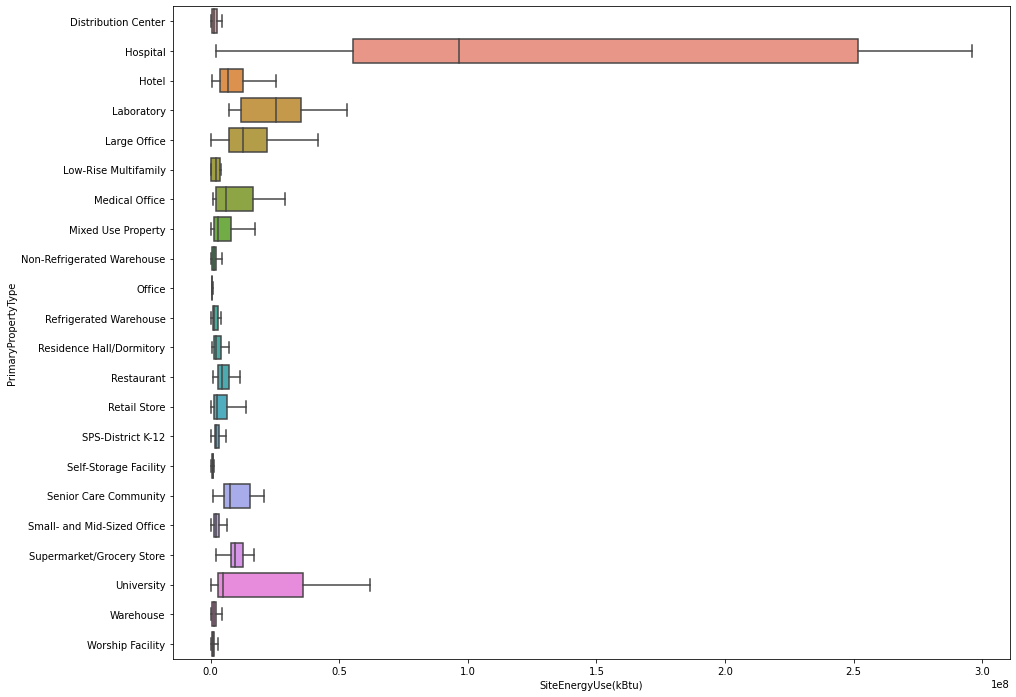

In [54]:
plt.figure(figsize=(15,12))
azerty = df[['SiteEnergyUse(kBtu)', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)', data=azerty, orient='h', showfliers=False)

In [55]:
df_mean.sort_values(by='SiteEnergyUse(kBtu)')

PrimaryPropertyType  SiteEnergyUse(kBtu)
9                        Office         5.800745e+05
15        Self-Storage Facility         9.125161e+05
21             Worship Facility         1.171687e+06
8    Non-Refrigerated Warehouse         1.726504e+06
20                    Warehouse         1.961577e+06
5          Low-Rise Multifamily         1.968272e+06
17  Small- and Mid-Sized Office         2.610650e+06
0           Distribution Center         2.801173e+06
14            SPS-District K-12         2.905481e+06
11     Residence Hall/Dormitory         3.138390e+06
10       Refrigerated Warehouse         3.522608e+06
13                 Retail Store         4.864268e+06
12                   Restaurant         5.181074e+06
7            Mixed Use Property         7.934994e+06
6                Medical Office         9.583750e+06
18    Supermarket/Grocery Store         9.983782e+06
2                         Hotel         1.131862e+07
16        Senior Care Community         1.169515e+07
19                   University         1.190550e+07
4                  Large Office         1.707059e+07
3                    Laboratory         2.620197e+07
1                      Hospital         4.554688e+07

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

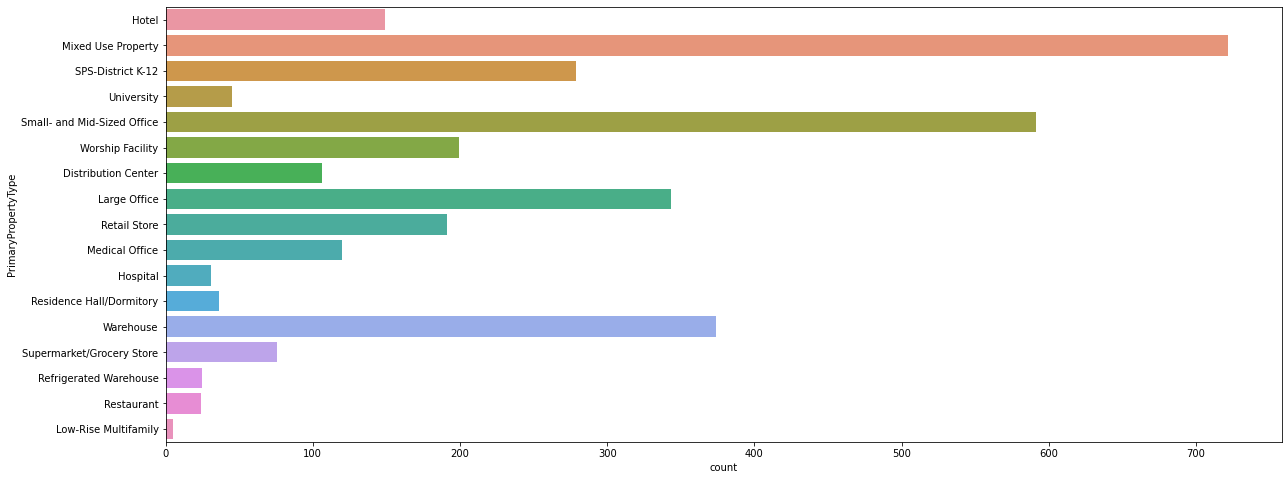

In [56]:
# au vu de ces données :
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Non-Refrigerated Warehouse', 'Warehouse')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Laboratory', 'Hospital')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility', 'Worship Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Office', 'Small- and Mid-Sized Office')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Senior Care Community', 'Medical Office')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [57]:
len(df['PrimaryPropertyType'].unique())

17

In [58]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [59]:
#Neighborhood
df['Neighborhood']=df['Neighborhood'].str.upper()
df['Neighborhood']=df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print(df['Neighborhood'].value_counts())

DOWNTOWN                 728
GREATER DUWAMISH         686
MAGNOLIA / QUEEN ANNE    301
LAKE UNION               295
NORTHEAST                243
EAST                     242
NORTHWEST                174
BALLARD                  138
NORTH                    132
CENTRAL                  110
SOUTHEAST                 92
DELRIDGE                  92
SOUTHWEST                 83
Name: Neighborhood, dtype: int64


In [60]:
#ListOfAllPropertyUseTypes
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [61]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       nan, 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Retail Store', 'Senior Care Community',
       'Medical Office', 'Hospital (General Medical & Surgical)',
       'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Laboratory',
       'Supermarket/Grocery Store', 'Convention Center',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [62]:
df_chi2=df.copy(deep=True)
df_chi2=df_chi2[(~df_chi2['SiteEnergyUse(kBtu)'].isna())&(~df_chi2['LargestPropertyUseType'].isna())]
# First, we need to calculate our IQR.
q1 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.25)                 
q3 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.75)
iqr = q3 - q1

# Now let's calculate upper and lower bounds.
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

# Let us create our bins:
num_bins = 5
bin_width = (upper - lower) / num_bins
bins = [lower + i*bin_width for i in range(num_bins)]
bins += [upper, float('inf')]  # Now we add our last bin, which will contain any value greater than the upper-bound of the IQR.

# Let us create our labels:
labels = [f'Bucket {i}' for i in range(1,num_bins+1)]
labels.append('Outside IQR')

# Finally, we add a new column to the df:
df_chi2['khi2'] = pd.cut(df_chi2['SiteEnergyUse(kBtu)'], bins=bins, labels=labels)
df_chi2.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0   MAYFLOWER PARK HOTEL                     659000030                    7   
1        PARAMOUNT HOTEL                     659000220                    7   
2           WESTIN HOTEL                     659000475                    7   
3              HOTEL MAX                     659000640                    7   
4  WARWICK SEATTLE HOTEL                     659000970                    7   

  Neighborhood  YearBuilt  NumberofBuildings  ...       Outlier     Latitude  \
0     DOWNTOWN       1927                1.0  ...           NaN  47.61219025   
1     DOWNTOWN       1996                1.0  ...           NaN  47.61310583   
2     DOWNTOWN       1969                1.0  ...           NaN  47.61334897   
3     DOWNTOWN       1926                1.0  ...  High Outlier  47.61421585   
4     DOWNTOWN       1980                1.0  ...           NaN   47.6137544   

       Longitude     City State ZipCode Address  parking_ratio  \
0  -122.33799744  SEATTLE    WA   98101     NaN       0.000000   
1  -122.33335756  SEATTLE    WA   98101     NaN      14.545314   
2  -122.33769944  SEATTLE    WA   98101     NaN       0.000000   
3  -122.33660889  SEATTLE    WA   98101     NaN       0.000000   
4   -122.3409238  SEATTLE    WA   98121     NaN      10.392860   

   building_ratio         khi2  
0      100.000000     Bucket 4  
1       85.454686     Bucket 4  
2      100.000000  Outside IQR  
3      100.000000  Outside IQR  
4       89.607140     Bucket 5  

[5 rows x 33 columns]

In [63]:
cross_table = pd.crosstab(index=df_chi2['khi2'],columns=df_chi2['LargestPropertyUseType'])
cross_table

LargestPropertyUseType  Adult Education  Automobile Dealership  Bank Branch  \
khi2                                                                          
Bucket 2                              2                      4            8   
Bucket 3                              2                      7            0   
Bucket 4                              0                      0            0   
Bucket 5                              0                      0            0   
Outside IQR                           0                      0            0   

LargestPropertyUseType  College/University  Convention Center  Courthouse  \
khi2                                                                        
Bucket 2                                 8                  1           0   
Bucket 3                                15                  0           0   
Bucket 4                                 4                  0           0   
Bucket 5                                 4                  0           0   
Outside IQR                             13                  1           2   

LargestPropertyUseType  Data Center  Distribution Center  Financial Office  \
khi2                                                                         
Bucket 2                          0                   69                 2   
Bucket 3                          0                   29                 4   
Bucket 4                          0                    4                 1   
Bucket 5                          0                    2                 0   
Outside IQR                       5                    2                 0   

LargestPropertyUseType  Fire Station  ...  Restaurant  Retail Store  \
khi2                                  ...                             
Bucket 2                           0  ...           1            80   
Bucket 3                           2  ...          11            67   
Bucket 4                           0  ...           8            30   
Bucket 5                           0  ...           2             9   
Outside IQR                        0  ...           1            12   

LargestPropertyUseType  Self-Storage Facility  Senior Care Community  \
khi2                                                                   
Bucket 2                                   52                      2   
Bucket 3                                    2                     13   
Bucket 4                                    0                     11   
Bucket 5                                    0                      2   
Outside IQR                                 0                     10   

LargestPropertyUseType  Social/Meeting Hall  Strip Mall  \
khi2                                                      
Bucket 2                                  9           2   
Bucket 3                                  9           4   
Bucket 4                                  2           1   
Bucket 5                                  0           3   
Outside IQR                               0           2   

LargestPropertyUseType  Supermarket/Grocery Store  \
khi2                                                
Bucket 2                                        2   
Bucket 3                                        8   
Bucket 4                                       39   
Bucket 5                                       28   
Outside IQR                                     1   

LargestPropertyUseType  Urgent Care/Clinic/Other Outpatient  \
khi2                                                          
Bucket 2                                                  0   
Bucket 3                                                  4   
Bucket 4                                                  0   
Bucket 5                                                  0   
Outside IQR                                               4   

LargestPropertyUseType  Wholesale Club/Supercenter  Worship Facility  
khi2                                                     

In [64]:
def cramers_v(cross_tabs):
    """
    Prints the degrees of freedom, effect size thresholds, and Cramer's V value.

    Args:
        cross_tabs: A crosstab dataframe.
    """


    # effect size data frame for cramer's v function
    data = np.array([[1, .1, .3, .5],
       [2, .07, .21, .35],
       [3, .06, .17, .29],
       [4, .05,.15,.25],
       [5, .04, .13, .22]])
    sizes = pd.DataFrame(data, columns=['Degrees of Freedom', 'Small Effect', 'Medium Effect', 'Large Effect'])

    # getting the chi sq. stat
    chi2 = stats.chi2_contingency(cross_tabs)[0]
    # calculating the total number of observations
    n = cross_tabs.sum().sum()
    # getting the degrees of freedom
    dof = min(cross_tabs.shape)-1
    # calculating cramer's v
    v = np.sqrt(chi2/(n*dof))
    # printing results
    print(f'V = {v}')
    print(f'Cramer\'s V Degrees of Freedom = {dof}')
    print(f'\nEffect Size Thresholds\n{sizes}\n')

cramers_v(cross_table)

V = 0.35013201957931966
Cramer's V Degrees of Freedom = 4

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22



In [65]:
# la colonne LargestPropertyUseType semble intéréssante au vu du khi2, mais beaucoup de travail

In [66]:
from scipy.stats import chi2_contingency as chi2_contingency
khi2, pval , ddl , contingent_theorique = chi2_contingency(cross_table)
print(f'khi2 : {khi2}, pval : {pval}, degré de liberté : {ddl}')

khi2 : 1587.817168056545, pval : 8.007046769174071e-204, degré de liberté : 224


In [67]:
#latitude-longitude
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

In [68]:
to_drop=[
    'TaxParcelIdentificationNumber', #pas d'interet
    'PropertyName', # pas d'interet
    'ListOfAllPropertyUseTypes', # pas d'interet
    'LargestPropertyUseType',# a voir mais beaucoup de taf
    'SecondLargestPropertyUseType',# a voir mais beaucoup de taf
    'ThirdLargestPropertyUseType',# a voir mais beaucoup de taf + nan +++
    "YearsENERGYSTARCertified", #trop de nan + pas d'interet
    'DefaultData',
    'ComplianceStatus',
    'City',
    'State',
    'Address',
    'ZipCode',
    'Comments',
    'Outlier'
]

In [69]:
print(df['SiteEnergyUse(kBtu)'].mean())
print(df[df['Outlier'].isin(['High Outlier', 'High outlier'])]['SiteEnergyUse(kBtu)'].mean())
print(df['TotalGHGEmissions'].mean())
print(df[df['Outlier'].isin(['High Outlier', 'High outlier'])]['TotalGHGEmissions'].mean())

8068387.644949252
20523515.4375
176.99036589053475
343.655625


In [70]:
df=df[~df['Outlier'].isin(['High Outlier', 'High outlier'])]

In [71]:
df[~df['Comments'].isna()]['Comments']

62      Under construction starting 6/2013 (old buildi...
436     Part of McKinstry's campus, property operates ...
437     One of two office buildings on McKinstry's cam...
595     Part of McKinstry’s campus, this remodeled war...
719     Construction completed in mid 2015. The buildi...
1358    Under construction starting 6/2013 (old buildi...
1360    Under construction starting 6/2013 (old buildi...
1373    Under construction starting 6/2015 (old buildi...
2108    Under construction starting 09/2014 (old build...
2230    Part of McKinstry's campus, the office space f...
2319    Part of McKinstry's campus, property includes ...
2381    Property now has two buildings: Thornton Creek...
Name: Comments, dtype: object

In [72]:
df=df.drop(columns=to_drop)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 0 to 3375
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3300 non-null   int64  
 1   DataYear                3300 non-null   int64  
 2   BuildingType            3300 non-null   object 
 3   PrimaryPropertyType     3300 non-null   object 
 4   CouncilDistrictCode     3300 non-null   int64  
 5   Neighborhood            3300 non-null   object 
 6   YearBuilt               3300 non-null   int64  
 7   NumberofBuildings       3300 non-null   float64
 8   NumberofFloors          3300 non-null   float64
 9   PropertyGFABuilding(s)  3300 non-null   int64  
 10  ENERGYSTARScore         2197 non-null   float64
 11  SiteEnergyUse(kBtu)     3291 non-null   float64
 12  TotalGHGEmissions       3291 non-null   float64
 13  Latitude                3300 non-null   float64
 14  Longitude               3300 non-null   

## Nan values energystarscore

In [74]:
print(len(df[~df['ENERGYSTARScore'].isna()]))
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(df.groupby('OSEBuildingID')['ENERGYSTARScore'].transform('max'))
len(df[~df['ENERGYSTARScore'].isna()])

2197


2252

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='PrimaryPropertyType'>

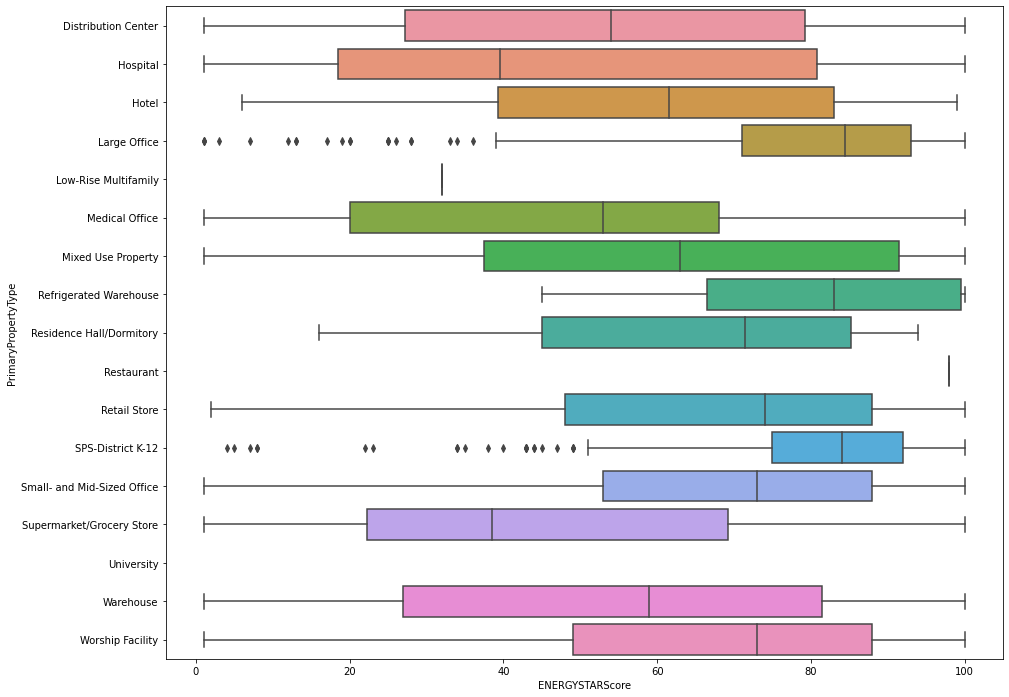

In [75]:
plt.figure(figsize=(15,12))
azerty = df[['ENERGYSTARScore', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='ENERGYSTARScore', data=azerty, orient='h')

In [76]:
df['BuildingAge']=df['DataYear']-df['YearBuilt']
df.drop(columns=['YearBuilt'],inplace=True)

<AxesSubplot:>

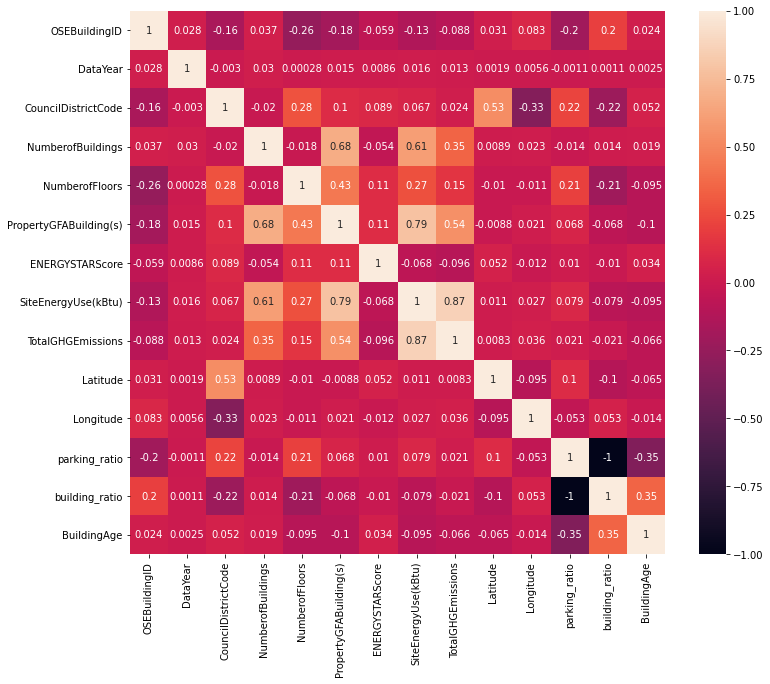

In [77]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [78]:
locationlist=[]
for index, row in df.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])

In [79]:
map = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=12)
for point in range(0, len(df)):
    folium.CircleMarker(locationlist[point],radius=5).add_to(map)
map

In [80]:
a = df[['CouncilDistrictCode', 'Neighborhood']].groupby('CouncilDistrictCode')['Neighborhood'].apply(list)

In [81]:
def count_(list_code):
    dict_count={}
    items = set(list_code)
    for item in items :
        dict_count[item]=list_code.count(item)
    return dict_count
for i in range (1,8):
    print(count_(a[i]))

{'GREATER DUWAMISH': 61, 'DELRIDGE': 92, 'SOUTHWEST': 83}
{'EAST': 2, 'GREATER DUWAMISH': 617, 'SOUTHEAST': 84, 'DOWNTOWN': 87}
{'SOUTHEAST': 8, 'LAKE UNION': 29, 'CENTRAL': 110, 'NORTHEAST': 2, 'EAST': 226, 'DOWNTOWN': 21, 'GREATER DUWAMISH': 7}
{'NORTHEAST': 231, 'NORTH': 4, 'LAKE UNION': 92}
{'NORTHEAST': 8, 'NORTH': 128, 'NORTHWEST': 128}
{'BALLARD': 138, 'NORTHWEST': 46, 'LAKE UNION': 44}
{'EAST': 14, 'MAGNOLIA / QUEEN ANNE': 296, 'DOWNTOWN': 617, 'LAKE UNION': 125}


In [82]:
locationlist_2=[]
locationlist=[]
df_1=df[df['CouncilDistrictCode']==2]
df_2=df[df['CouncilDistrictCode']==3]
locationlist=[]
for index, row in df_1.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])
for index, row in df_2.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist_2.append([lat, long])
map = folium.Map(location=[df_1['Latitude'].median(), df_1['Longitude'].median()], zoom_start=12)
for point in range(0, len(df_1)):
    folium.CircleMarker(locationlist[point],radius=5, color='red').add_to(map)
for point in range(0, len(df_2)):
    folium.CircleMarker(locationlist_2[point],radius=5, color='blue').add_to(map)
map

In [83]:
# il semblerait que la variable CouncilDistrictCode ne soit pas pertinente -> on preferera encoder les quartiers

In [84]:
df.drop(columns=['CouncilDistrictCode'], inplace=True)

In [85]:
df['BuildingType'].unique()

array(['NonResidential', 'SPS-District K-12', 'Campus'], dtype=object)

In [86]:
numeric_columns= list(df.select_dtypes('float').columns) +list(df.select_dtypes('int').columns)
numeric_columns

['NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Latitude',
 'Longitude',
 'parking_ratio',
 'building_ratio',
 'OSEBuildingID',
 'DataYear',
 'PropertyGFABuilding(s)',
 'BuildingAge']

In [87]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


for column in list(df.select_dtypes('O').columns):
    encoder=OneHotEncoder(sparse=False)
    cat_encoded = pd.DataFrame(encoder.fit_transform(df[[column]]))

    cat_encoded.columns = encoder.get_feature_names([column])
    df.reset_index(inplace=True, drop=True)
    df= pd.concat([df, cat_encoded], axis=1)
    df.drop(columns=[column], inplace=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [88]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Latitude', 'Longitude', 'parking_ratio',
       'building_ratio', 'BuildingAge', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_SPS-District K-12',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery 

<AxesSubplot:>

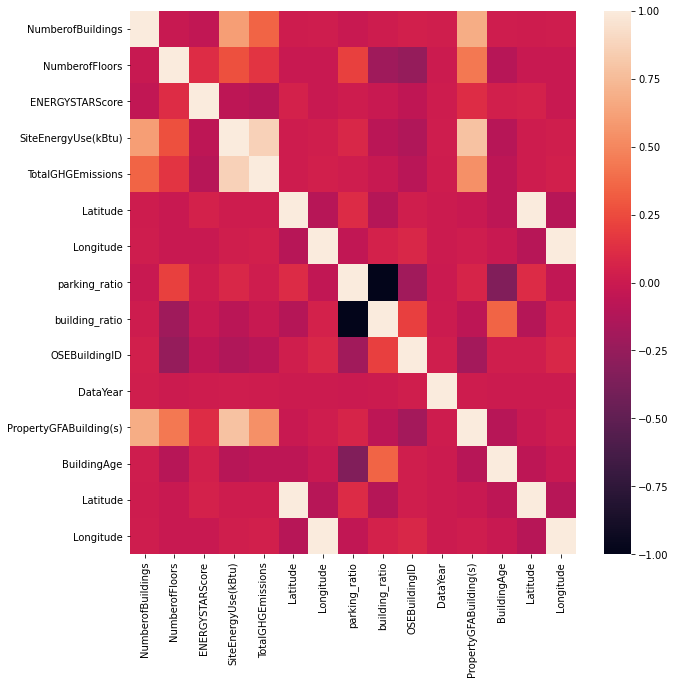

In [89]:
numeric_columns.append('Latitude')
numeric_columns.append('Longitude')
plt.figure(figsize=(10,10))
sns.heatmap(df[numeric_columns].corr())

<AxesSubplot:>

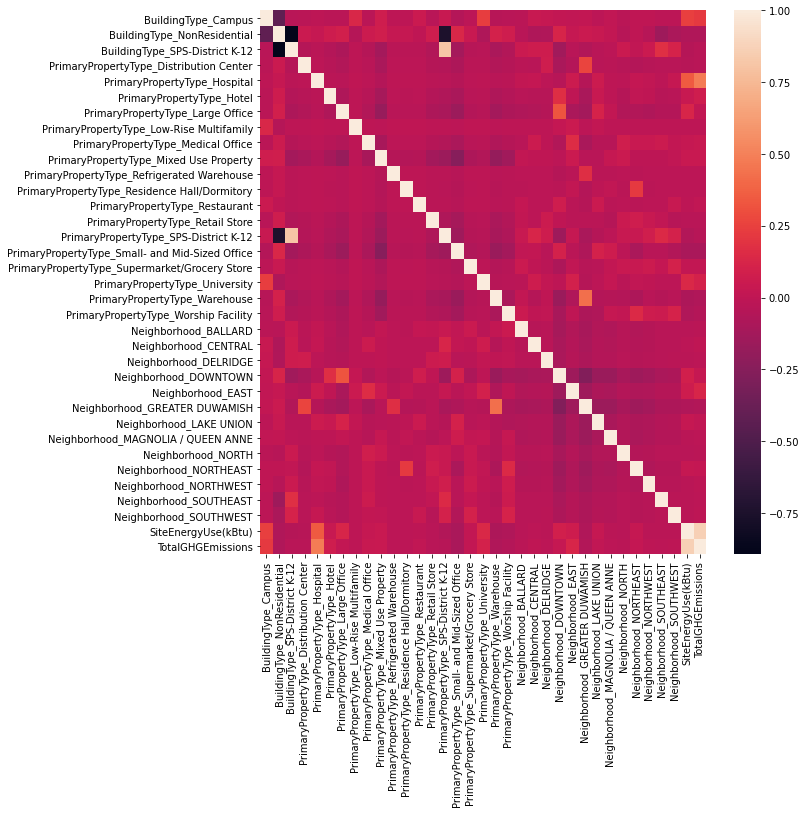

In [90]:
cat_col = [i for i in list(df.columns) if i not in numeric_columns]
cat_col.append('SiteEnergyUse(kBtu)')
cat_col.append('TotalGHGEmissions')
plt.figure(figsize=(10,10))
sns.heatmap(df[cat_col].corr())

# Normaliser les colonnes

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


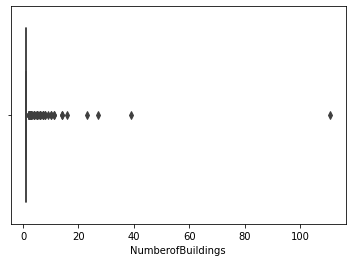

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


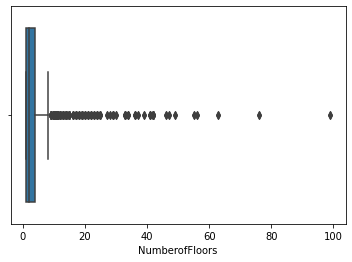

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


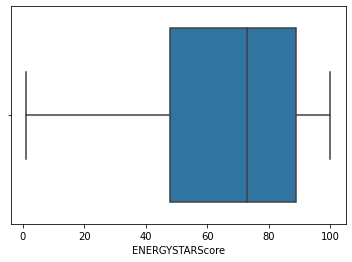

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


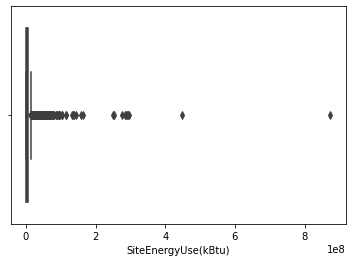

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


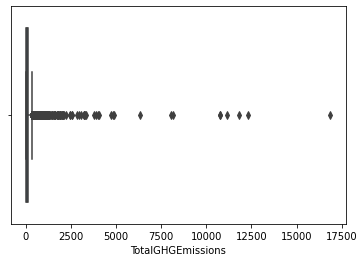

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


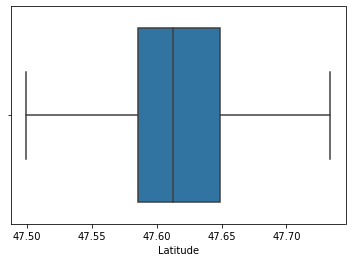

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


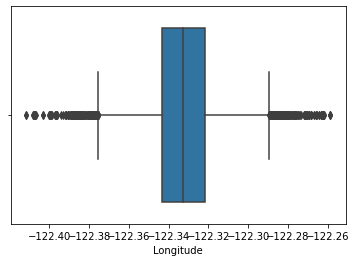

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


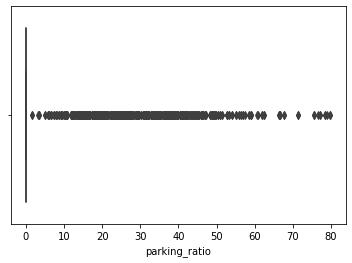

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


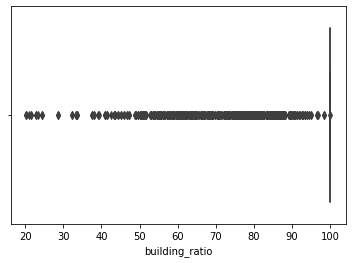

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


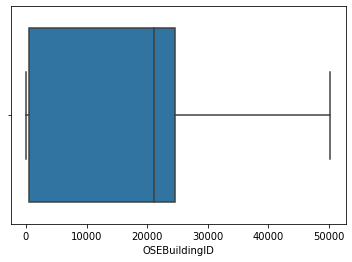

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


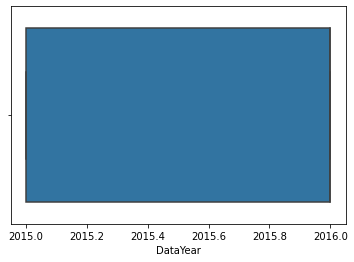

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


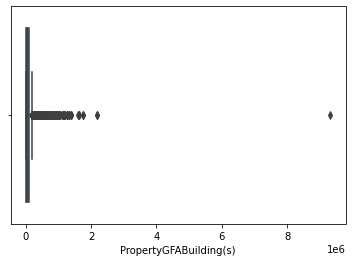

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


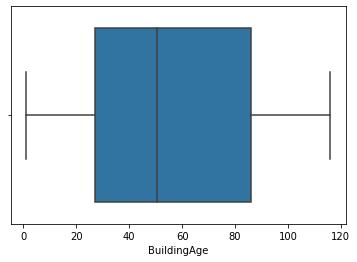

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


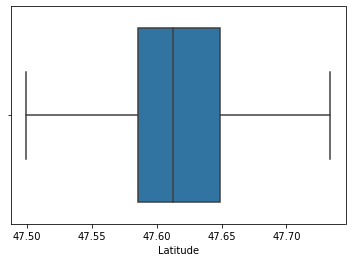

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


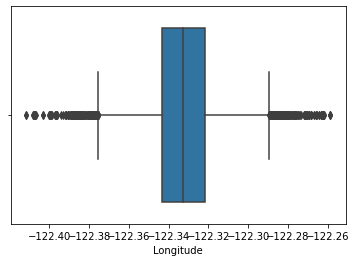

In [91]:
for column in numeric_columns :
    sns.boxplot(df[column])
    plt.show()

In [92]:
#je vais voir si j'enleve les données ou site energie use et total emission sont très élévées, j'obtiens de meilleures graphiques
'''q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)
q
df_ = df_[df_['SiteEnergyUse(kBtu)']<q]'''

"q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)\nq\ndf_ = df_[df_['SiteEnergyUse(kBtu)']<q]"

On peut voir pas mal d'outliers -> Robustscaler \
Pour les targets -> on veut normaliser la distrbution : boxcox ou log

In [93]:
to_robust = [
    'NumberofBuildings',
    'NumberofFloors',
    'ENERGYSTARScore',
    'PropertyGFABuilding(s)',
    'BuildingAge',
    'parking_ratio',
    'building_ratio'
            ]
to_drop = ['Latitude',
             'Longitude',
          'OSEBuildingID',
          'DataYear']
targets=['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',]

In [94]:

for column in to_robust:
    transformer = RobustScaler(unit_variance=True).fit(df[[column]])
    df[column] = transformer.transform(df[[column]])

In [95]:
df['NumberofBuildings'].value_counts()

0.000000      3234
1.348980        15
2.697959        14
5.395918         8
6.744898         6
4.046939         5
8.093877         4
9.442857         2
17.536734        2
12.140816        2
13.489795        2
35.073467        1
51.261221        1
10.791836        1
20.234693        1
29.677549        1
148.387745       1
Name: NumberofBuildings, dtype: int64

In [96]:
df['DataYear'] = df['DataYear'].map({2015:0, 2016:1})

In [97]:
df['DataYear'].unique()

array([0, 1])

In [98]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Latitude', 'Longitude', 'parking_ratio',
       'building_ratio', 'BuildingAge', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_SPS-District K-12',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery 

In [ ]:
pd

# Site energy use prediction

## Fonctions

In [99]:
def grid_search(model, grid, scoring, X,y):
    search = GridSearchCV(model, grid,
                           scoring = scoring, n_jobs=-1)
    search.fit(X,y)
    return search.best_score_, search.best_params_, search.best_estimator_

In [100]:
#cv scoring
scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

def training(model, X, y, cv=5, scoring=scoring):
    res = cross_validate(model, X, y, cv = 5, scoring=scoring)
    scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
    }
    return scores

In [101]:
from sklearn.model_selection import learning_curve

def learning_curves(estimator, X, y, train_size, cv=5):
    '''Take :
    - estimator = model
    - X=data
    - y=target
    - train_size = range for testing (ex : [25,50,75,100,250,500,750,1000,1150, 2000, 3000]
    -cv = cross validation
    '''
    train_sizes, train_scores, test_scores= learning_curve(estimator, X, y, train_sizes=train_size, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()

In [102]:
def adjusted_r_squarred(r_squarred, X, y):
    return 1-(1-r_squarred)*(len(y)-1)/(len(y)-X.shape[1]-1)

def calcul_mdape(y_true, y_pred):
    return np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100

## Dernier ajustements

In [103]:
df_energy = df.copy()

In [104]:
df_energy=df_energy[df_energy['SiteEnergyUse(kBtu)']>0]
df_energy = df_energy[df_energy['SiteEnergyUse(kBtu)']<df_energy['SiteEnergyUse(kBtu)'].max()]
df_energy=df_energy.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [105]:
# https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203
def box_cot(df_series):
    # Python3 code to show Box-cox Transformation
    # of non-normal data

    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(df_series)

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.distplot(df_series, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
                 label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.show();
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


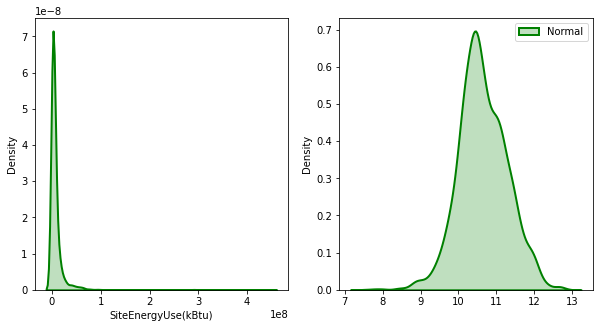

Lambda value used for Transformation: -0.0478094102062404


In [106]:
fitted_data, fitted_lambda = box_cot(df_energy['SiteEnergyUse(kBtu)'])

In [107]:
df_energy['energy_box_cox'] = fitted_data

In [108]:
# drop energystar score for my primary approch
df_energy_full = df_energy.copy()
df_energy = df_energy.drop(columns=['ENERGYSTARScore'])

## prepare X and y

In [109]:
X = df_energy.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y = df_energy['SiteEnergyUse(kBtu)']
y_boxcox = df_energy['energy_box_cox']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)


## Baseline

In [110]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train, y_train)
y_predict_dummy_median = dummy_regr_median.predict(X_test)
print(f'mae : {median_absolute_error(y_test,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test,y_predict_dummy_median)}')

mae : 1663251.15625
rmse : 19070933.214304615
r2 : -0.0735863187985395
mdape : 71.43393627112489


In [111]:
scores_baseline_energie= {'time': 0.00, 
                          'MAE': -median_absolute_error(y_test,y_predict_dummy_median),
                          'RMSE': -mean_squared_error(y_test,y_predict_dummy_median)**0.5,
                          'r2': r2_score(y_test,y_predict_dummy_median)}

In [112]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train_box, y_train_box)
y_predict_dummy_median = dummy_regr_median.predict(X_test_box)
print(f'mae : {median_absolute_error(y_test_box,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test_box,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test_box,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test_box,y_predict_dummy_median)}')

scores_baseline_energie_box= {'time': 0.00, 
                          'MAE': -median_absolute_error(y_test_box,y_predict_dummy_median),
                          'RMSE': -mean_squared_error(y_test_box,y_predict_dummy_median)**0.5,
                          'r2': r2_score(y_test_box,y_predict_dummy_median)}

mae : 0.4224549657923866
rmse : 0.6547927782982101
r2 : -0.012513007494700856
mdape : 4.0093421136673895


## First models

In [113]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### Linear regression

<AxesSubplot:>

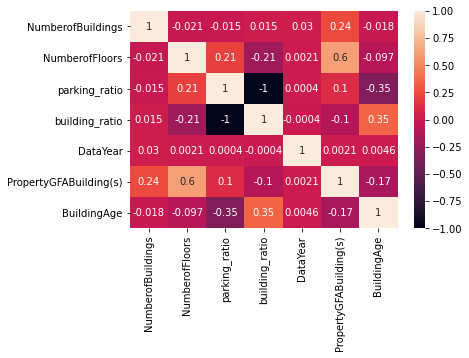

In [114]:
sns.heatmap(X[['NumberofBuildings',
 'NumberofFloors',
 'parking_ratio',
 'building_ratio',
 'DataYear',
 'PropertyGFABuilding(s)',
 'BuildingAge']].corr(), annot=True)

In [115]:
X_lin = X.drop(columns=['building_ratio'])

In [116]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X_lin, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.01
MAE linear regression : -4634916.89
RMSE linear regression : -12945683.85
r2 linear regression : 0.48


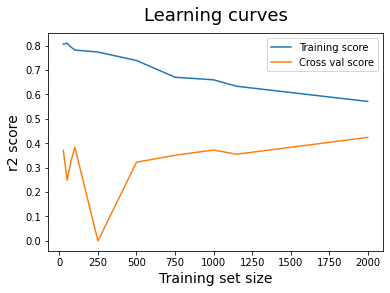

In [117]:
train_sizes = [25,50,75,100,250,500,750,1000,1150, 2000]
learning_curves(lr, X_lin,y,train_sizes)

In [118]:
# Le modele n'a pas l'air d'overfitter mais je vais essayer un lasso /Ridge 
#pour voir si je peux augmenter les performances

In [119]:
#with target boxcox
lr = LinearRegression()
lr_scores_boxcox = training(lr, X_lin, y_boxcox)

print(f"score {model} : {lr_scores_boxcox['time']}")
print(f"MAE {model} : {lr_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lr_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lr_scores_boxcox['r2']}")

score linear regression : 0.01
MAE linear regression : -0.36
RMSE linear regression : -0.47
r2 linear regression : 0.34


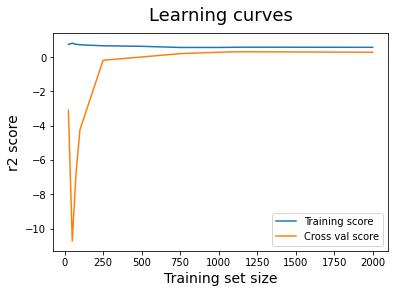

In [120]:
train_sizes = [25,50,75,100,250,500,750,1000,1150, 2000]
learning_curves(lr, X_lin,y_boxcox,train_sizes)

### Ridge

In [121]:
from sklearn.linear_model import Ridge
model = Ridge()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4577431.003632237,
 best_params : {'alpha': 10.0},
 best_estimator : Ridge(alpha=10.0)


In [122]:
model = Ridge(alpha=10)
ridge_scores = training(model, X, y)

print(f"score {model} : {ridge_scores['time']}")
print(f"MAE {model} : {ridge_scores['MAE']}")
print(f"RMSE {model} : {ridge_scores['RMSE']}")
print(f"r2 {model} : {ridge_scores['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -4577431.0
RMSE Ridge(alpha=10) : -12966892.1
r2 Ridge(alpha=10) : 0.48


In [123]:
#target boxcox
model = Ridge(alpha=10)
ridge_scores_box = training(model, X, y_boxcox)

print(f"score {model} : {ridge_scores_box['time']}")
print(f"MAE {model} : {ridge_scores_box['MAE']}")
print(f"RMSE {model} : {ridge_scores_box['RMSE']}")
print(f"r2 {model} : {ridge_scores_box['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -0.36
RMSE Ridge(alpha=10) : -0.47
r2 Ridge(alpha=10) : 0.33


### Lasso

In [124]:
from sklearn.linear_model import Lasso
model = Lasso()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4634851.811693668,
 best_params : {'alpha': 10.0},
 best_estimator : Lasso(alpha=10.0)


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+17, tolerance: 1.354e+14
  model = cd_fast.enet_coordinate_descent(


In [125]:
model = Lasso(alpha=10)
lasso_scores = training(model, X, y)

print(f"score {model} : {lasso_scores['time']}")
print(f"MAE {model} : {lasso_scores['MAE']}")
print(f"RMSE {model} : {lasso_scores['RMSE']}")
print(f"r2 {model} : {lasso_scores['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.709e+15, tolerance: 8.720e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.213e+17, tolerance: 1.295e+14
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

score Lasso(alpha=10) : 0.11
MAE Lasso(alpha=10) : -4634851.81
RMSE Lasso(alpha=10) : -12945649.11
r2 Lasso(alpha=10) : 0.48


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.753e+16, tolerance: 1.264e+14
  model = cd_fast.enet_coordinate_descent(


In [126]:
#target boxcox
model = Lasso(alpha=10)
lasso_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {lasso_scores_boxcox['time']}")
print(f"MAE {model} : {lasso_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lasso_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lasso_scores_boxcox['r2']}")

score Lasso(alpha=10) : 0.0
MAE Lasso(alpha=10) : -0.53
RMSE Lasso(alpha=10) : -0.67
r2 Lasso(alpha=10) : -0.34


### KNN

In [127]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
grid = {'n_neighbors': np.arange(5,30)}

best_score,best_params,best_estimator = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4122589.6366638066,
 best_params : {'n_neighbors': 5},
 best_estimator : KNeighborsRegressor()


In [128]:
model = KNeighborsRegressor(n_neighbors=5)
knn_scores = training(model, X, y)

print(f"score {model} : {knn_scores['time']}")
print(f"MAE {model} : {knn_scores['MAE']}")
print(f"RMSE {model} : {knn_scores['RMSE']}")
print(f"r2 {model} : {knn_scores['r2']}")

score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -4122589.64
RMSE KNeighborsRegressor() : -13428247.22
r2 KNeighborsRegressor() : 0.49


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:4

In [129]:
#target boxcox
model = KNeighborsRegressor(n_neighbors=5)
knn_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {knn_scores_boxcox['time']}")
print(f"MAE {model} : {knn_scores_boxcox['MAE']}")
print(f"RMSE {model} : {knn_scores_boxcox['RMSE']}")
print(f"r2 {model} : {knn_scores_boxcox['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -0.29
RMSE KNeighborsRegressor() : -0.4
r2 KNeighborsRegressor() : 0.52


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Random Forest

In [130]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [131]:
model = RandomForestRegressor(
    n_estimators= 150,
    min_samples_split=2,
    min_samples_leaf=1,)
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor(n_estimators=150) : 1.31
MAE RandomForestRegressor(n_estimators=150) : -2100464.17
RMSE RandomForestRegressor(n_estimators=150) : -7736897.74
r2 RandomForestRegressor(n_estimators=150) : 0.81


In [132]:
#boxcox
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y_boxcox)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')


In [133]:
model = RandomForestRegressor()
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor() : 0.8
MAE RandomForestRegressor() : -0.15
RMSE RandomForestRegressor() : -0.24
r2 RandomForestRegressor() : 0.83


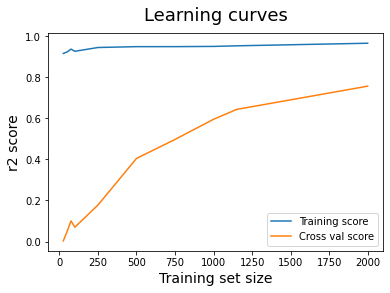

In [134]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [135]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': np.arange(40,200, 20), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(2,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [136]:
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.42
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -2850628.32
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -8223228.02
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.79


In [137]:
#target boxcox
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.37
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.23
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.33
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.67


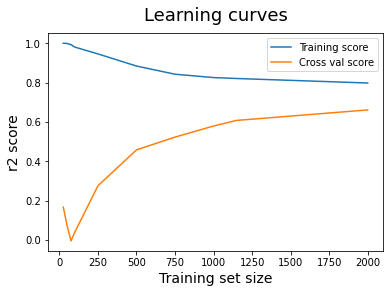

In [138]:
learning_curves(model, X, y_boxcox, train_sizes)

### Analyse

In [139]:
lr_scores

{'time': 0.01, 'MAE': -4634916.89, 'RMSE': -12945683.85, 'r2': 0.48}

In [140]:
scores = pd.DataFrame([
    scores_baseline_energie,
    lr_scores,
         ridge_scores,
         knn_scores,
         randomforest_scores, 
        XGBOST_scores], index=['baseline', 'lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores

time           MAE          RMSE        r2
baseline      0.00  1.663251e+06  1.907093e+07 -0.073586
lr            0.01  4.634917e+06  1.294568e+07  0.480000
ridge         0.00  4.577431e+06  1.296689e+07  0.480000
knn           0.00  4.122590e+06  1.342825e+07  0.490000
randomforest  1.31  2.100464e+06  7.736898e+06  0.810000
XGBOOST       0.42  2.850628e+06  8.223228e+06  0.790000

In [141]:
scores_baseline_energie_box

{'time': 0.0,
 'MAE': -0.4224549657923866,
 'RMSE': -0.6547927782982101,
 'r2': -0.012513007494700856}

In [142]:
scores_box = pd.DataFrame([
    scores_baseline_energie_box,
    lr_scores_boxcox,
         ridge_scores_box,
         knn_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['baseline', 'lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

time       MAE      RMSE        r2
baseline      0.00  0.422455  0.654793 -0.012513
lr            0.01  0.360000  0.470000  0.340000
ridge         0.00  0.360000  0.470000  0.330000
knn           0.00  0.290000  0.400000  0.520000
randomforest  0.80  0.150000  0.240000  0.830000
XGBOOST       0.37  0.230000  0.330000  0.670000

Text(0.5, 1.0, 'MAE')

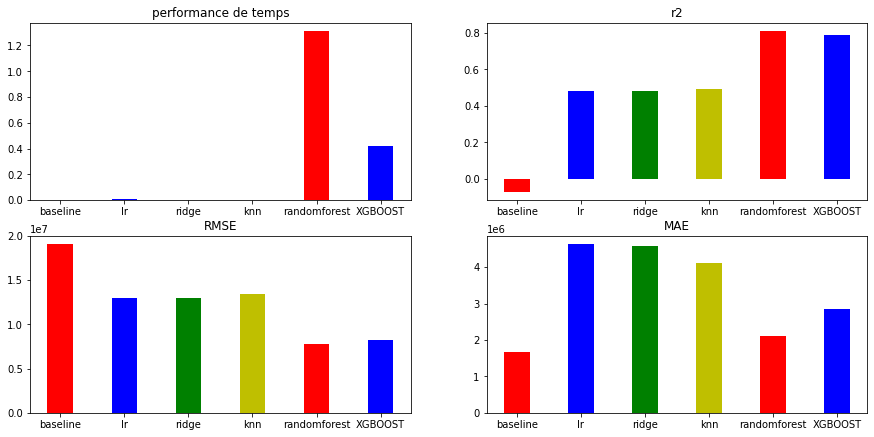

In [143]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores.index, height=list(scores['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps')
plt.subplot(422)
plt.bar(x=scores.index, height=list(scores['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2')
plt.subplot(423)
plt.bar(x=scores.index, height=list(scores['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE')
plt.subplot(424)
plt.bar(x=scores.index, height=list(scores['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE')

Text(0.5, 1.0, 'MAE boxcox')

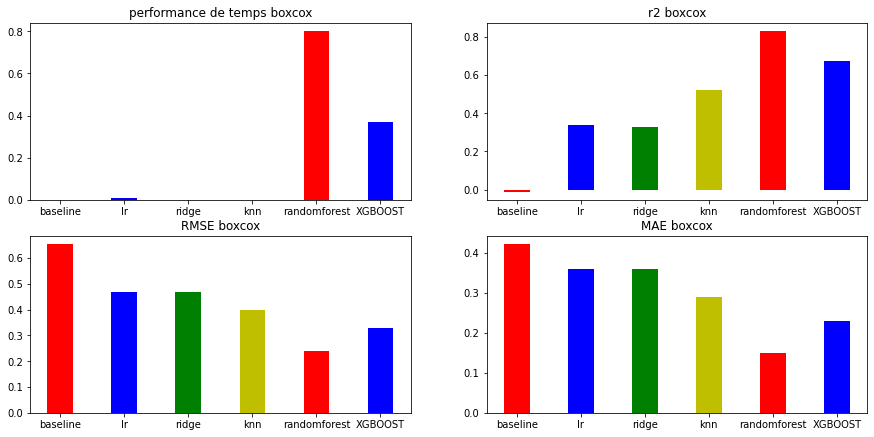

In [144]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores_box.index, height=list(scores_box['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps boxcox')
plt.subplot(422)
plt.bar(x=scores_box.index, height=list(scores_box['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2 boxcox')
plt.subplot(423)
plt.bar(x=scores_box.index, height=list(scores_box['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE boxcox')
plt.subplot(424)
plt.bar(x=scores_box.index, height=list(scores_box['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE boxcox')

On constate que le modele random forest et XGBOOST sont les deux modeles qui dominent

## Entrainement Random Forest

In [145]:
model = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model.fit(X_train, y_train)
#pred
prediction = model.predict(X_test)
#features importances
model.feature_importances_.reshape(1,-1).shape

(1, 40)

In [146]:
#boxcox
model_box = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model_box.fit(X_train_box, y_train_box)
#pred
prediction_box = model_box.predict(X_test_box)
#features importances
model_box.feature_importances_.reshape(1,-1).shape

(1, 40)

## Analyse

Text(0.5, 1.0, 'features importances sans boxcox')

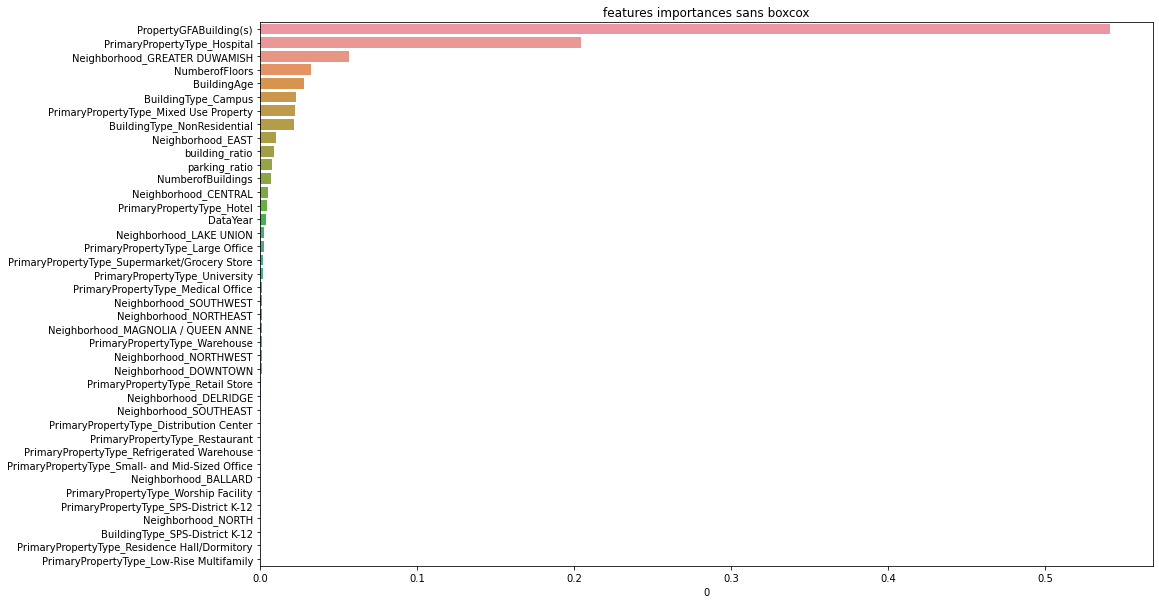

In [147]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances sans boxcox')

Text(0.5, 1.0, 'features importances avec boxcox')

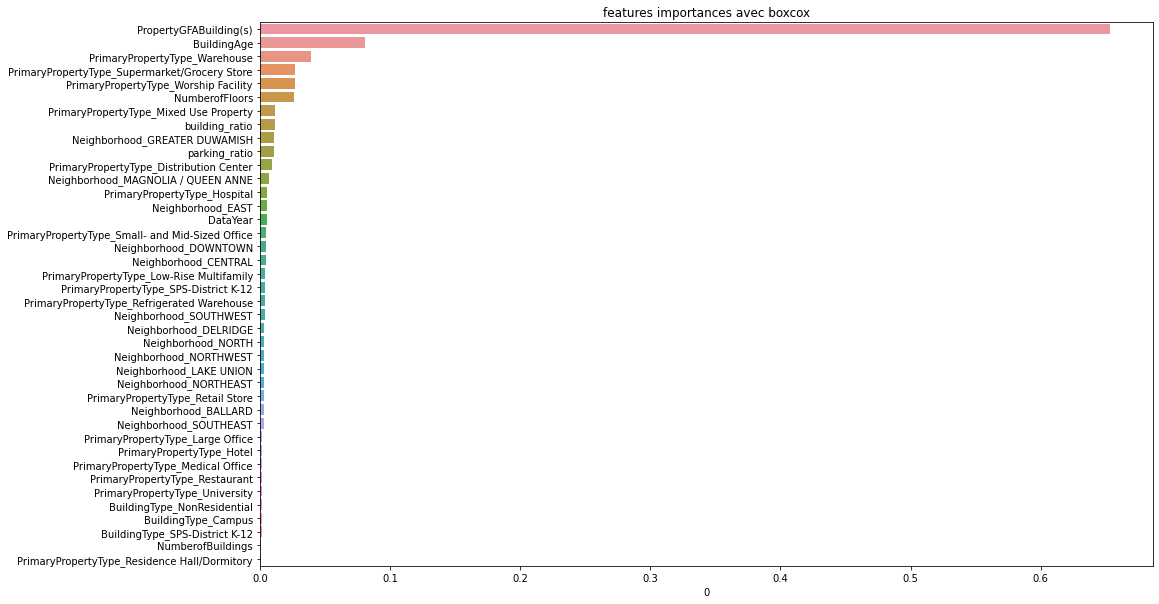

In [148]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model_box.feature_importances_.reshape(1,-1), columns=X_train_box.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances avec boxcox')

In [149]:
'''df_test=pd.concat([X_test, y_test], axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test=pd.concat([df_test, y_test_box], axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test=pd.concat([df_test, predictions], axis=1, )'''

'df_test=pd.concat([X_test, y_test], axis=1)\ndf_test.reset_index(drop=True, inplace=True)\ndf_test=pd.concat([df_test, y_test_box], axis=1)\ndf_test.reset_index(drop=True, inplace=True)\ndf_test=pd.concat([df_test, predictions], axis=1, )'

In [150]:
y_test=y_test.reset_index(drop=True)

In [151]:
predictions = pd.DataFrame({'pred': prediction, 'pred_box': prediction_box})

predictions.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test=y_test.reset_index(drop=True)
y_test_box=y_test_box.reset_index(drop=True)

df_test=pd.concat([predictions, X_test, y_test,y_test_box], axis=1)

In [152]:
df_test.isnull().sum()

pred                                               0
pred_box                                           0
DataYear                                           0
NumberofBuildings                                  0
NumberofFloors                                     0
PropertyGFABuilding(s)                             0
parking_ratio                                      0
building_ratio                                     0
BuildingAge                                        0
BuildingType_Campus                                0
BuildingType_NonResidential                        0
BuildingType_SPS-District K-12                     0
PrimaryPropertyType_Distribution Center            0
PrimaryPropertyType_Hospital                       0
PrimaryPropertyType_Hotel                          0
PrimaryPropertyType_Large Office                   0
PrimaryPropertyType_Low-Rise Multifamily           0
PrimaryPropertyType_Medical Office                 0
PrimaryPropertyType_Mixed Use Property        

In [153]:
df_test['pred_box']=df_test['pred_box'].apply(lambda x : inv_boxcox(x, fitted_lambda))

In [154]:
median_absolute_error(list(df_test['SiteEnergyUse(kBtu)']), df_test['pred_box'])

2824086.3433392416

In [155]:
df_test['diff_pred_truth']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred'])
df_test['diff_pred_truth_box']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred_box'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


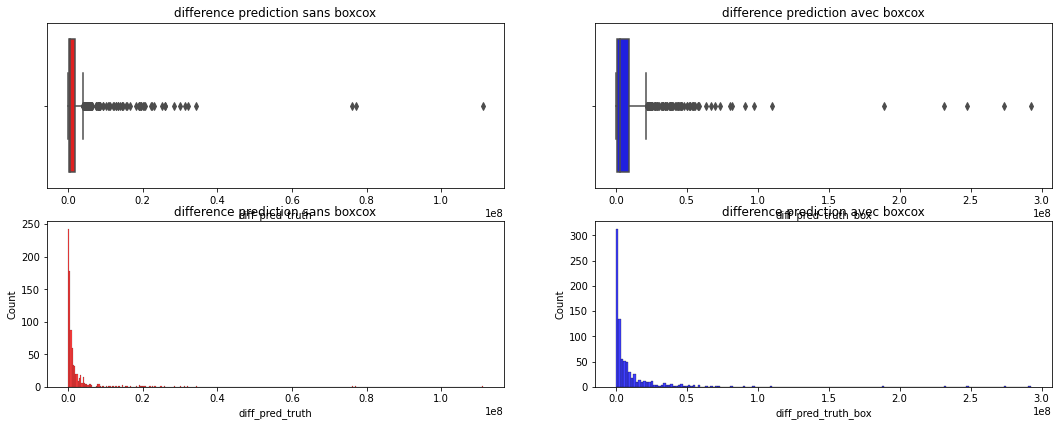

In [156]:
plt.figure(figsize=(18,14))
plt.subplot(421)
sns.boxplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(422)
sns.boxplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox')
plt.subplot(423)
sns.histplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(424)
sns.histplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox');

In [157]:
df_test['diff_pred_truth_box'].median()/df_test['SiteEnergyUse(kBtu)'].median()

1.1821550871150255

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

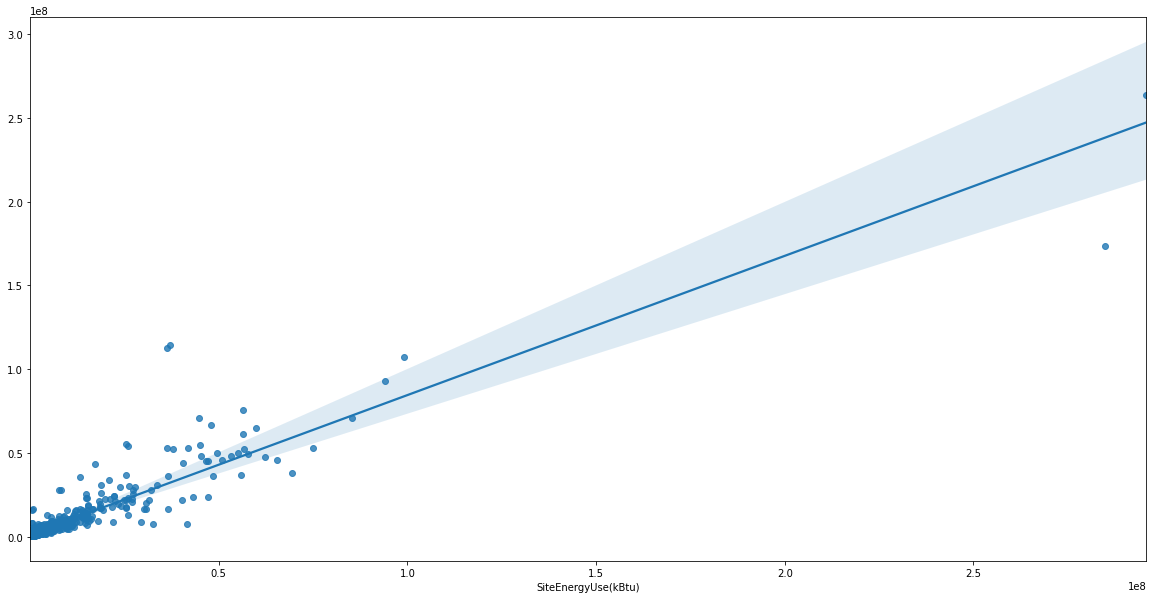

In [158]:
plt.figure(figsize=(20,10))
sns.regplot(y_test, prediction)

In [159]:
df_test[df_test['diff_pred_truth_box']==df_test['diff_pred_truth_box'].max()]

pred      pred_box  DataYear  NumberofBuildings  NumberofFloors  \
402  2.637119e+08  3.376767e+06         0                0.0        2.697959   

     PropertyGFABuilding(s)  parking_ratio  building_ratio  BuildingAge  \
402               22.734699            0.0             0.0    -0.811674   

     BuildingType_Campus  ...  Neighborhood_MAGNOLIA / QUEEN ANNE  \
402                  0.0  ...                                 0.0   

     Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
402                 0.0                     0.0                     0.0   

     Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  SiteEnergyUse(kBtu)  \
402                     0.0                     0.0          295812640.0   

     energy_box_cox  diff_pred_truth  diff_pred_truth_box  
402       10.657961     3.210072e+07         2.924359e+08  

[1 rows x 46 columns]

In [160]:
df_test['SiteEnergyUse(kBtu)'].mean()

7556884.770450329

## Test améliorations 

### : remove columns with low interest

In [161]:
# Drop features peu impactantes
df_energy_features = df_energy.drop(columns=list(features.index[:28]))

In [162]:
X_features = df_energy_features.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_features = df_energy_features['SiteEnergyUse(kBtu)']


In [163]:
model = RandomForestRegressor()
res = cross_validate(model, X_features, y_features, cv = 5, scoring=scoring)

randomforest_scores_f = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")

score RandomForestRegressor() : 0.11
MAE RandomForestRegressor() : -7489924.72
RMSE RandomForestRegressor() : -18939880.03
r2 RandomForestRegressor() : -0.18


In [164]:
randomforest_scores_f

{'time': 0.11, 'MAE': -7489924.72, 'RMSE': -18939880.03, 'r2': -0.18}

In [165]:
# Clairement nul !

### Remove outliers

In [166]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.15)
    q3 = df_in[col_name].quantile(0.85)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [167]:
df_energy_without_outliers = remove_outlier(df_energy, 'SiteEnergyUse(kBtu)')
len(df_energy_without_outliers)/len(df_energy)

0.9477383863080685

In [168]:
X_outliers = df_energy_without_outliers.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_outliers = df_energy_without_outliers['SiteEnergyUse(kBtu)']
y_outliers_box=df_energy_without_outliers['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_outliers, y_outliers )
randomforest_scores_f_box = training(model_box, X_outliers, y_outliers_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.78
MAE RandomForestRegressor() : -1078137.63
RMSE RandomForestRegressor() : -1908307.7
r2 RandomForestRegressor() : 0.84
______
score RandomForestRegressor() : 0.75
MAE RandomForestRegressor() : -0.15
RMSE RandomForestRegressor() : -0.23
r2 RandomForestRegressor() : 0.81


<AxesSubplot:xlabel='energy_box_cox', ylabel='Count'>

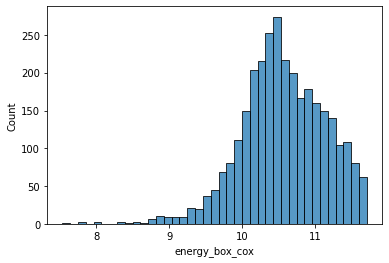

In [169]:
sns.histplot(y_outliers_box)

In [170]:
# Permet d'obternir les meilleurs résultats sans gridsearch !

## EnergyStarScore impact?

In [171]:
df_energy_full.isnull().sum()

DataYear                                              0
NumberofBuildings                                     0
NumberofFloors                                        0
PropertyGFABuilding(s)                                0
ENERGYSTARScore                                    1039
SiteEnergyUse(kBtu)                                   0
TotalGHGEmissions                                     0
parking_ratio                                         0
building_ratio                                        0
BuildingAge                                           0
BuildingType_Campus                                   0
BuildingType_NonResidential                           0
BuildingType_SPS-District K-12                        0
PrimaryPropertyType_Distribution Center               0
PrimaryPropertyType_Hospital                          0
PrimaryPropertyType_Hotel                             0
PrimaryPropertyType_Large Office                      0
PrimaryPropertyType_Low-Rise Multifamily        

In [172]:
df_energy_full=df_energy_full[~df_energy_full['ENERGYSTARScore'].isna()]
X_stars = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_stars = df_energy_full['SiteEnergyUse(kBtu)']
y_stars_box = df_energy_full['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.66
MAE RandomForestRegressor() : -1981240.82
RMSE RandomForestRegressor() : -9752308.67
r2 RandomForestRegressor() : 0.77
______
score RandomForestRegressor() : 0.59
MAE RandomForestRegressor() : -0.11
RMSE RandomForestRegressor() : -0.17
r2 RandomForestRegressor() : 0.91


In [173]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_stars, y_stars)

0.7656960292104062

In [174]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_stars, y_stars_box)

0.9083158375171155

In [175]:
X_without_stars = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'ENERGYSTARScore','energy_box_cox' ])
y_without_stars = df_energy_full['SiteEnergyUse(kBtu)']
y_without_stars_box = df_energy_full['energy_box_cox']


model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.59
MAE RandomForestRegressor() : -1991365.7
RMSE RandomForestRegressor() : -8544483.1
r2 RandomForestRegressor() : 0.82
______
score RandomForestRegressor() : 0.53
MAE RandomForestRegressor() : -0.13
RMSE RandomForestRegressor() : -0.2
r2 RandomForestRegressor() : 0.86


In [176]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_without_stars, y_without_stars)

0.8167153284671532

In [177]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_without_stars, y_without_stars_box)

0.8574452554744525

In [178]:
#l'EnergieStarScore semble aveoir un impact APRES boxcox 🧐

# Emission 

In [179]:
df_emission = df.copy(deep=True)

## Derniers ajustements

In [180]:
df_emission=df_emission[df_emission['TotalGHGEmissions']>0]

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

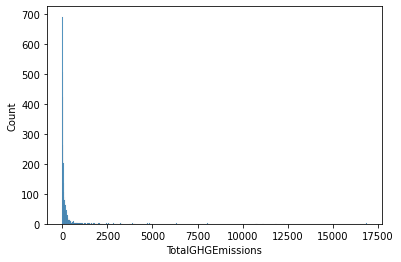

In [181]:
sns.histplot(df_emission['TotalGHGEmissions'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


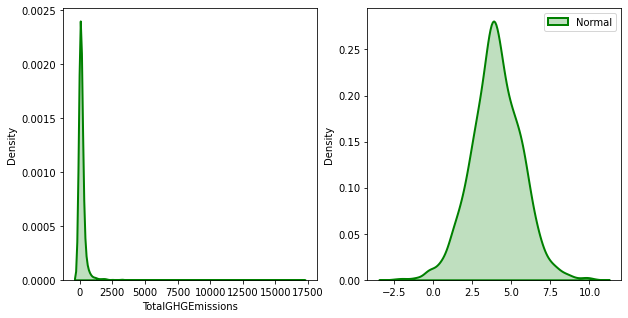

Lambda value used for Transformation: 0.011912038252615238


In [182]:
fitted_data, fitted_lambda = box_cot(df_emission['TotalGHGEmissions'])
df_emission['boxcox_emission']=fitted_data

<AxesSubplot:xlabel='boxcox_emission', ylabel='Count'>

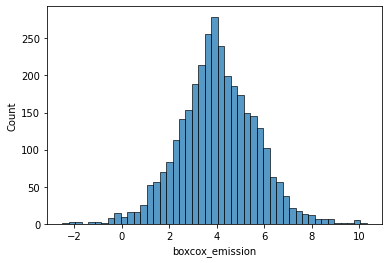

In [183]:
sns.histplot(df_emission['boxcox_emission'])

In [184]:
df_emission=df_emission.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [185]:
# drop energystar score for my primary approch
df_emission_full = df_emission.copy()
df_emission = df_emission_full.drop(columns=['ENERGYSTARScore'])

## Prepare X & y

In [186]:
X = df_emission.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y = df_emission['TotalGHGEmissions']
y_boxcox = df_emission['boxcox_emission']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)

## Baseline

In [187]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train, y_train)
y_predict_dummy_median = dummy_regr_median.predict(X_test)
print(f'mae : {median_absolute_error(y_test,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test,y_predict_dummy_median)}')


mae : 36.03000000000001
rmse : 607.264471581525
r2 : -0.04132636757802355
mdape : 75.40983606557377


In [188]:
y.median()

49.105000000000004

## models evaluation :

### Linear Reg

In [189]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.02
MAE linear regression : -46512481.7
RMSE linear regression : -1191297091.1
r2 linear regression : -7853511084186.03


In [190]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores_box = training(lr, X, y_boxcox)

print(f"score {model} : {lr_scores_box['time']}")
print(f"MAE {model} : {lr_scores_box['MAE']}")
print(f"RMSE {model} : {lr_scores_box['RMSE']}")
print(f"r2 {model} : {lr_scores_box['r2']}")

score linear regression : 0.02
MAE linear regression : -397743.3
RMSE linear regression : -10187174.48
r2 linear regression : -195487410713205.7


### Random Forest

In [191]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [192]:
model = RandomForestRegressor()
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor() : 0.92
MAE RandomForestRegressor() : -67.55
RMSE RandomForestRegressor() : -313.99
r2 RandomForestRegressor() : 0.74


In [193]:
model = RandomForestRegressor()
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor() : 0.8
MAE RandomForestRegressor() : -0.48
RMSE RandomForestRegressor() : -0.69
r2 RandomForestRegressor() : 0.79


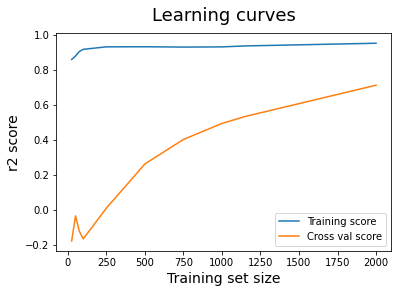

In [194]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [195]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': np.arange(40,200, 20), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(2,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [196]:
model = GradientBoostingRegressor()
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor() : 0.2
MAE GradientBoostingRegressor() : -92.4
RMSE GradientBoostingRegressor() : -315.07
r2 GradientBoostingRegressor() : 0.73


In [197]:
#target boxcox
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.36
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.75
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.99
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.56


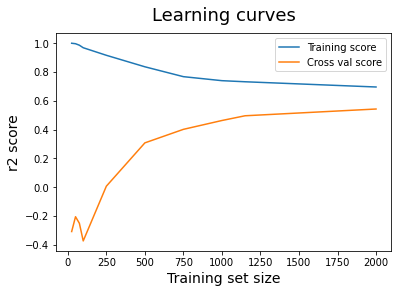

In [198]:
learning_curves(model, X, y_boxcox, train_sizes)

In [199]:
scores = pd.DataFrame([lr_scores,
         randomforest_scores, 
        XGBOST_scores], index=['lr','randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores_box = pd.DataFrame([lr_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['lr', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

time   MAE  RMSE    r2
lr            0.01  0.36  0.47  0.34
randomforest  0.80  0.48  0.69  0.79
XGBOOST       0.36  0.75  0.99  0.56

In [200]:
scores

time          MAE          RMSE            r2
lr            0.02  46512481.70  1.191297e+09 -7.853511e+12
randomforest  0.92        67.55  3.139900e+02  7.400000e-01
XGBOOST       0.20        92.40  3.150700e+02  7.300000e-01

## remove outliers ?

In [201]:
df_emission_without_outliers = remove_outlier(df_emission, 'TotalGHGEmissions')
len(df_emission_without_outliers)/len(df_emission)

0.9503351614868982

In [202]:
#comparaison des outliers energy <-> emission
len(df_energy_without_outliers[df_energy_without_outliers.index.isin(
    list(df_emission_without_outliers.index) )])/len(df_energy_without_outliers)

0.983553692357304

In [203]:
df_emission_without_outliers

DataYear  NumberofBuildings  NumberofFloors  PropertyGFABuilding(s)  \
0            0                0.0        4.496598                0.842130   
1            0                0.0        4.046939                0.843521   
3            0                0.0        7.194557                1.230701   
4            0                0.0        0.000000                0.262341   
5            0                0.0        4.046939                0.731139   
...        ...                ...             ...                     ...   
3295         1                0.0       -0.449660               -0.715347   
3296         1                0.0       -0.449660               -0.639539   
3297         1                0.0       -0.449660               -0.697694   
3298         1                0.0       -0.449660               -0.678384   
3299         1                0.0       -0.449660               -0.593351   

      SiteEnergyUse(kBtu)  TotalGHGEmissions  parking_ratio  building_ratio  \
0            6.981428e+06             249.43       0.000000        0.000000   
1            8.354235e+06             263.51      19.621331      -19.621331   
3            1.482910e+07             507.70      14.019755      -14.019755   
4            1.205198e+07             304.62      51.578139      -51.578139   
5            6.252842e+06             208.46       0.000000        0.000000   
...                   ...                ...            ...             ...   
3295         8.497457e+05              20.94       0.000000        0.000000   
3296         9.502762e+05              32.17       0.000000        0.000000   
3297         5.765898e+06             223.54       0.000000        0.000000   
3298         7.194712e+05              22.11       0.000000        0.000000   
3299         1.152896e+06              41.27       0.000000        0.000000   

      BuildingAge  BuildingType_Campus  ...  Neighborhood_EAST  \
0        0.857402                  0.0  ...                0.0   
1       -0.720218                  0.0  ...                0.0   
3       -0.354393                  0.0  ...                0.0   
4       -0.788810                  0.0  ...                0.0   
5        0.880266                  0.0  ...                0.0   
...           ...                  ...  ...                ...   
3295    -0.560169                  0.0  ...                0.0   
3296    -0.880266                  0.0  ...                0.0   
3297    -0.194345                  0.0  ...                0.0   
3298    -0.537305                  0.0  ...                0.0   
3299     0.628762                  0.0  ...                0.0   

      Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                               0.0                      0.0   
1                               0.0                      0.0   
3                               0.0                      0.0   
4                               0.0                      0.0   
5                               0.0                      0.0   
...                             ...                      ...   
3295                            1.0                      0.0   
3296                            0.0                      0.0   
3297                            0.0                      0.0   
3298                            1.0                      0.0   
3299                            1.0                      0.0   

      Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                    0.0                 0.0   
1                                    0.0                 0.0   
3                                    0.0                 0.0   
4                                    0.0                 0.0   
5                                    0.0                 0.0   
...                                  ...                 ...   
3295                                 0.0                 0.0   
3296                                 0.0                 0

In [204]:
X_outliers = df_emission_without_outliers.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y_outliers = df_emission_without_outliers['TotalGHGEmissions']
y_outliers_box=df_emission_without_outliers['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_outliers, y_outliers )
randomforest_scores_f_box = training(model_box, X_outliers, y_outliers_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.82
MAE RandomForestRegressor() : -30.44
RMSE RandomForestRegressor() : -52.05
r2 RandomForestRegressor() : 0.74
______
score RandomForestRegressor() : 0.76
MAE RandomForestRegressor() : -0.48
RMSE RandomForestRegressor() : -0.68
r2 RandomForestRegressor() : 0.75


In [205]:
# les perfs sont meilleurs sans boxcox mais moins bonnes avec 🧐

## EnergyStar

In [206]:
df_emission_full=df_emission_full[~df_emission_full['ENERGYSTARScore'].isna()]
X_stars = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y_stars = df_emission_full['TotalGHGEmissions']
y_stars_box = df_emission_full['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.72
MAE RandomForestRegressor() : -66.42
RMSE RandomForestRegressor() : -332.78
r2 RandomForestRegressor() : 0.76
______
score RandomForestRegressor() : 0.61
MAE RandomForestRegressor() : -0.44
RMSE RandomForestRegressor() : -0.6
r2 RandomForestRegressor() : 0.82


In [207]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_stars, y_stars)

0.7555252387448841

In [208]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_stars, y_stars_box)

0.816643929058663

In [209]:
X_without_stars = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission', 'ENERGYSTARScore'])
y_without_stars = df_emission_full['TotalGHGEmissions']
y_without_stars_box = df_emission_full['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)

print('WITHOUT ENERGYSTARSCORE')

print('not boxcox')
print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print('boxcox')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

WITHOUT ENERGYSTARSCORE
not boxcox
score RandomForestRegressor() : 0.63
MAE RandomForestRegressor() : -61.82
RMSE RandomForestRegressor() : -323.27
r2 RandomForestRegressor() : 0.77
______
boxcox
score RandomForestRegressor() : 0.55
MAE RandomForestRegressor() : -0.43
RMSE RandomForestRegressor() : -0.61
r2 RandomForestRegressor() : 0.82


In [210]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_without_stars, y_without_stars)

0.7658181818181818

In [211]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_without_stars, y_without_stars_box)

0.8167272727272727

In [212]:
# ENERGYSTARScore semble améliorer les perfs après boxcox

# Last training

In [213]:
# remove outliers
# adding energiestarscores

In [214]:
df_without_outliers = df[df['SiteEnergyUse(kBtu)']>0]
df_without_outliers = df_without_outliers[df_without_outliers['TotalGHGEmissions']>0]
df_without_outliers = remove_outlier(df_without_outliers, 'TotalGHGEmissions')
df_without_outliers = remove_outlier(df_without_outliers, 'SiteEnergyUse(kBtu)')
len(df_without_outliers)/len(df)

0.9139393939393939

In [215]:
df_without_outliers= df_without_outliers.drop(columns=['Latitude','Longitude', 'OSEBuildingID' ])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


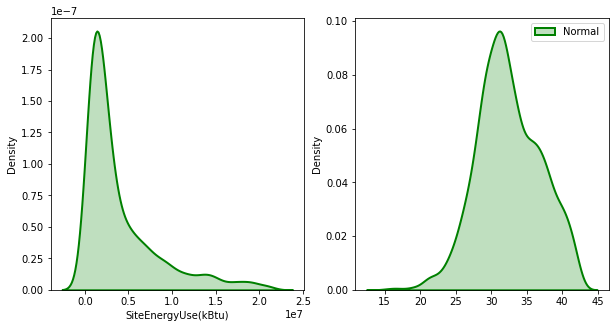

Lambda value used for Transformation: 0.09604980045999428


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


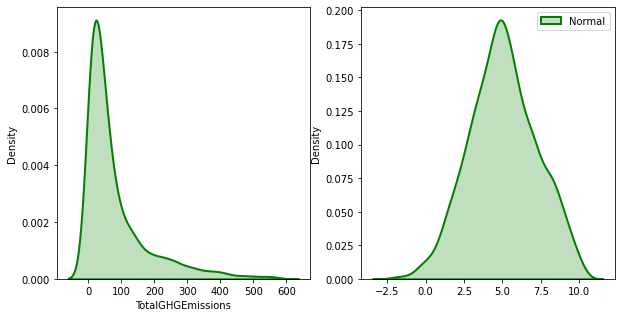

Lambda value used for Transformation: 0.13928034704477218


In [216]:
fitted_data_energie, fitted_lambda_energie = box_cot(df_without_outliers['SiteEnergyUse(kBtu)'])
fitted_data_emission, fitted_lambda_emission = box_cot(df_without_outliers['TotalGHGEmissions'])

In [217]:
df_without_outliers['emission_box']=fitted_data_emission
df_without_outliers['energie_box']=fitted_data_energie

In [218]:
df_without_outliers.describe()

DataYear  NumberofBuildings  NumberofFloors  PropertyGFABuilding(s)  \
count  3016.000000        3016.000000     3016.000000             3016.000000   
mean      0.501658           0.053226        0.559093                0.420413   
std       0.500080           0.532784        1.788082                1.450737   
min       0.000000           0.000000       -0.449660               -0.743350   
25%       0.000000           0.000000       -0.449660               -0.403228   
50%       1.000000           0.000000        0.000000               -0.079295   
75%       1.000000           0.000000        0.899320                0.600587   
max       1.000000          12.140816       43.617004               16.659661   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  TotalGHGEmissions  parking_ratio  \
count      2066.000000         3.016000e+03        3016.000000    3016.000000   
mean         -0.249567         4.022364e+06          82.459695       7.684654   
std           0.925665         4.324948e+06         100.283285      18.283371   
min          -2.368940         1.144100e+04           0.080000       0.000000   
25%          -0.822548         1.153492e+06          18.030000       0.000000   
50%           0.000000         2.218720e+06          44.060000       0.000000   
75%           0.526431         5.330372e+06         103.192500       0.000000   
max           0.888352         2.118754e+07         576.630000     107.671150   

       building_ratio  BuildingAge  ...  Neighborhood_GREATER DUWAMISH  \
count     3016.000000  3016.000000  ...                    3016.000000   
mean        -7.684653     0.110909  ...                       0.220822   
std         18.283372     0.748349  ...                       0.414870   
min       -107.671150    -1.131771  ...                       0.000000   
25%          0.000000    -0.514441  ...                       0.000000   
50%          0.000000     0.034296  ...                       0.000000   
75%          0.000000     0.834538  ...                       0.000000   
max          0.003941     1.497596  ...                       1.000000   

       Neighborhood_LAKE UNION  Neighborhood_MAGNOLIA / QUEEN ANNE  \
count              3016.000000                         3016.000000   
mean                  0.084218                            0.092175   
std                   0.277760                            0.289321   
min                   0.000000                            0.000000   
25%                   0.000000                            0.000000   
50%                   0.000000                            0.000000   
75%                   0.000000                            0.000000   
max                   1.000000                            1.000000   

       Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
count         3016.000000             3016.000000             3016.000000   
mean             0.042109                0.075265                0.054377   
std              0.200871                0.263863                0.226797   
min              0.000000                0.000000                0.000000   
25%              0.000000                0.000000                0.000000   
50%              0.000000                0.000000                0.000000   
75%              0.000000                0.000000                0.000000   
max              1.000000                1.000000                1.000000   

       Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  emission_box  \
count             3016.000000             3016.000000   3016.000000   
mean                 0.029509                0.025862      5.033285   
std                  0.169257                0.158750      2.186605   
min                  0.000000                0.000000     -2.129290   
25%                  0.000000                0.000000      3.561260   
50%                  0.000000                0.000000      4.984708   
75%                  0.000000                0.000000      6.

In [219]:
#df_without_outliers=df_without_outliers[~df_without_outliers['ENERGYSTARScore'].isna()]
X=df_without_outliers.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'emission_box','energie_box', 'ENERGYSTARScore' ])
y_emission=df_without_outliers['emission_box']
y_energie=df_without_outliers['energie_box']

In [220]:
df_without_outliers_star=df_without_outliers[~df_without_outliers.ENERGYSTARScore.isna()]

X_star=df_without_outliers_star.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'emission_box','energie_box', 'ENERGYSTARScore' ])
y_energie_star=df_without_outliers_star['energie_box']
y_emission_star=df_without_outliers_star['emission_box']

In [221]:
len(df_without_outliers_star)/len(df_without_outliers)

0.6850132625994695

## Energie

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energie, random_state=0)
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_energie_star, random_state=0)

In [223]:
grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
model = RandomForestRegressor()
tres_long=False
if tres_long :
    best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X, y_energie)
    print(best_score,best_params,best_estimator)

In [224]:
model = RandomForestRegressor(
                             max_depth=100,
                             max_features='auto',
                             n_estimators=1000)
model.fit(X_train, y_train)
prediction_energie = model.predict(X_test)

In [225]:
prediction_invboxcox=[]
y_test_invboxcox=[]
for i in prediction_energie:
    prediction_invboxcox.append(inv_boxcox(i, fitted_lambda_energie))
for j in y_test:
    y_test_invboxcox.append(inv_boxcox(j, fitted_lambda_energie))

In [226]:
print(f'mae : {median_absolute_error(y_test_invboxcox,prediction_invboxcox)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox,prediction_invboxcox)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox, prediction_invboxcox)}')
print(f'r squarred : {r2_score(y_test_invboxcox, prediction_invboxcox)}')

mae : 418063.2874661339
rmse : 1932730.0840136933
mdape : 21.141144415549327
r squarred : 0.8042286119346321


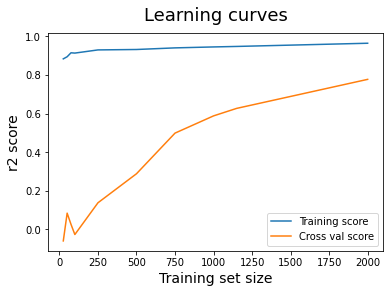

In [227]:
learning_curves(model, X, y_energie,train_size=train_sizes)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

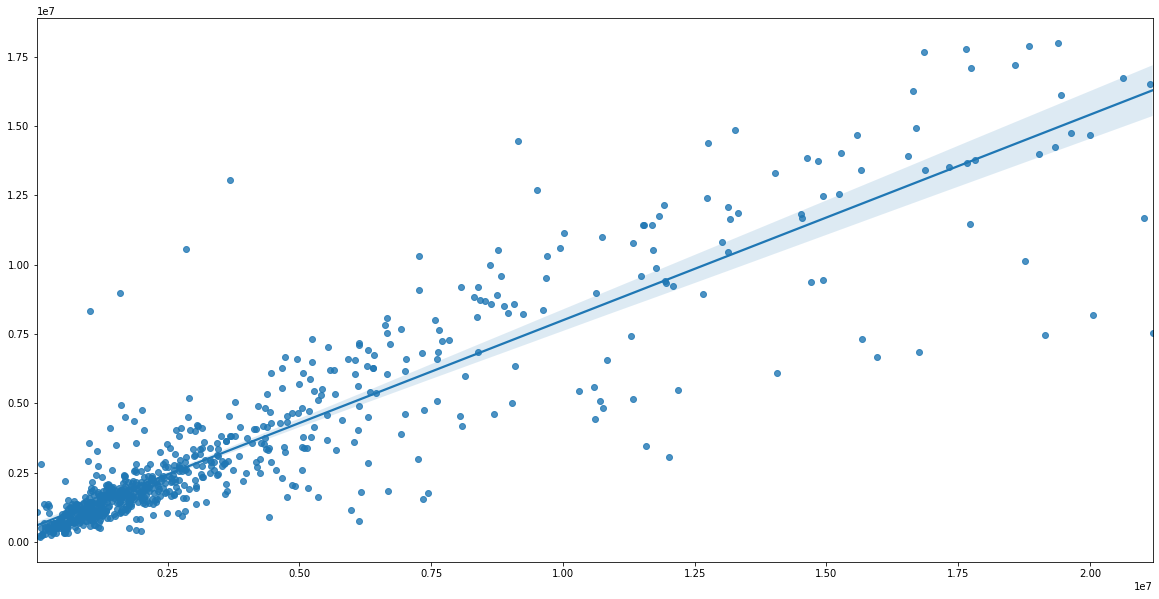

In [228]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox,prediction_invboxcox)

In [241]:
# energystarscore
grid={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
model = RandomForestRegressor()

best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X_star, y_energie_star)
print(best_score,best_params,best_estimator)

-1.0230468226840472 {'max_depth': 30, 'n_estimators': 800} RandomForestRegressor(max_depth=30, n_estimators=800)


In [242]:
model_star = RandomForestRegressor(
                             max_depth=30,
                             max_features='auto',
                             n_estimators=800)
model_star.fit(X_train_star, y_train_star)
prediction_energie_star = model_star.predict(X_test_star)

prediction_invboxcox_star=[]
y_test_invboxcox_star=[]
for i in prediction_energie_star:
    prediction_invboxcox_star.append(inv_boxcox(i, fitted_lambda_energie))
for j in y_test_star:
    y_test_invboxcox_star.append(inv_boxcox(j, fitted_lambda_energie))
    
print(f'mae : {median_absolute_error(y_test_invboxcox_star, prediction_invboxcox_star)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox_star, prediction_invboxcox_star)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox_star, prediction_invboxcox_star)}')
print(f'r squarred : {r2_score(y_test_invboxcox_star, prediction_invboxcox_star)}')

mae : 22.49019104640366
rmse : 118.3460120020231
mdape : 37.797015261282006
r squarred : 0.6473310695366263


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

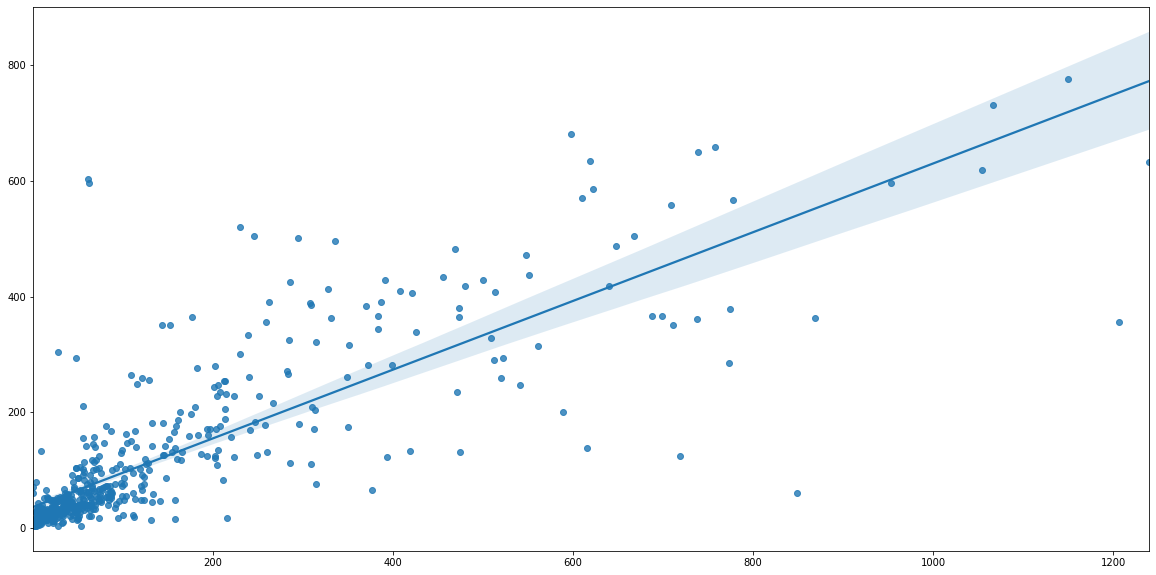

In [243]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox_star,prediction_invboxcox_star)

## Emission

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y_emission, random_state=0)
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_emission_star, random_state=0)

In [232]:
grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
model = RandomForestRegressor()
if tres_long :
    best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X, y_emission)
    print(best_score,best_params,best_estimator)

In [233]:
model = RandomForestRegressor(bootstrap=False,
                                max_depth=90,
                              n_estimators=600
                             )
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=90, n_estimators=600)

In [234]:
prediction_emission = model.predict(X_test)

prediction_invboxcox=[]
y_test_invboxcox=[]
for i in prediction_emission:
    prediction_invboxcox.append(inv_boxcox(i, fitted_lambda_emission))
for j in y_test:
    y_test_invboxcox.append(inv_boxcox(j, fitted_lambda_emission))
    
print(f'mae : {median_absolute_error(y_test_invboxcox,prediction_invboxcox)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox,prediction_invboxcox)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox, prediction_invboxcox)}')
print(f'r squarred : {r2_score(y_test_invboxcox, prediction_invboxcox)}')

mae : 7.441116153324675
rmse : 53.14633121459436
mdape : 17.76485995694609
r squarred : 0.713889268550987


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

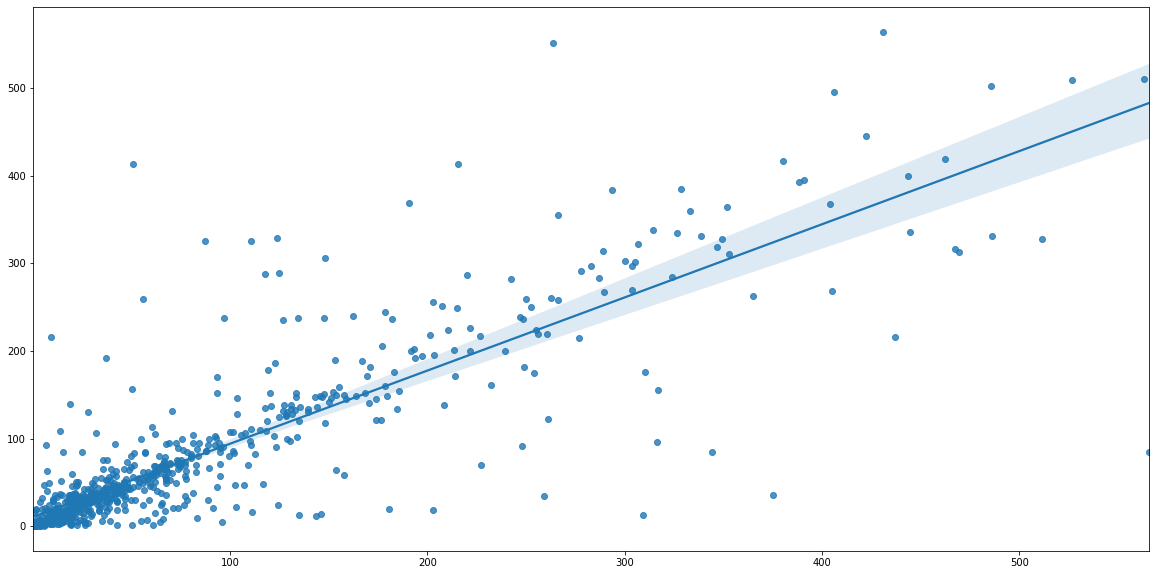

In [235]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox,prediction_invboxcox)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.591e+17, tolerance: 1.138e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e+17, tolerance: 8.720e+13 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.604e+17, tolerance: 1.295e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.368e+17, tolerance: 1.295e+14 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.202e+17, tolerance: 1.264e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.679e+17, tolerance: 8.328e+13 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.170e+17, tolerance: 8.720e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+17, tolerance: 1.138e+14 Linear regression models with null weight for the l1 regularization term a

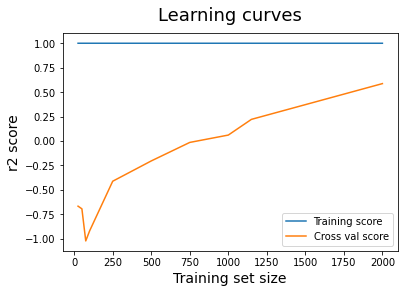

In [236]:
learning_curves(model, X,y_emission,train_size=train_sizes)

In [239]:
# energystarscore
grid={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
model = RandomForestRegressor()

best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X_star, y_emission_star)
print(best_score,best_params,best_estimator)

-0.6610765028425772 {'max_depth': 70, 'n_estimators': 400} RandomForestRegressor(max_depth=70, n_estimators=400)


In [240]:
model_star = RandomForestRegressor(
                             bootstrap=False,
                                max_depth=70,
                              n_estimators=400)
model_star.fit(X_train_star, y_train_star)
prediction_energie_star = model_star.predict(X_test_star)

prediction_invboxcox_star=[]
y_test_invboxcox_star=[]
for i in prediction_energie_star:
    prediction_invboxcox_star.append(inv_boxcox(i, fitted_lambda_emission))
for j in y_test_star:
    y_test_invboxcox_star.append(inv_boxcox(j, fitted_lambda_emission))
    
print(f'mae : {median_absolute_error(y_test_invboxcox_star, prediction_invboxcox_star)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox_star, prediction_invboxcox_star)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox_star, prediction_invboxcox_star)}')
print(f'r squarred : {r2_score(y_test_invboxcox_star, prediction_invboxcox_star)}')

mae : 8.670000000001004
rmse : 72.58729714908115
mdape : 16.68695757802313
r squarred : 0.47945780873719424


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

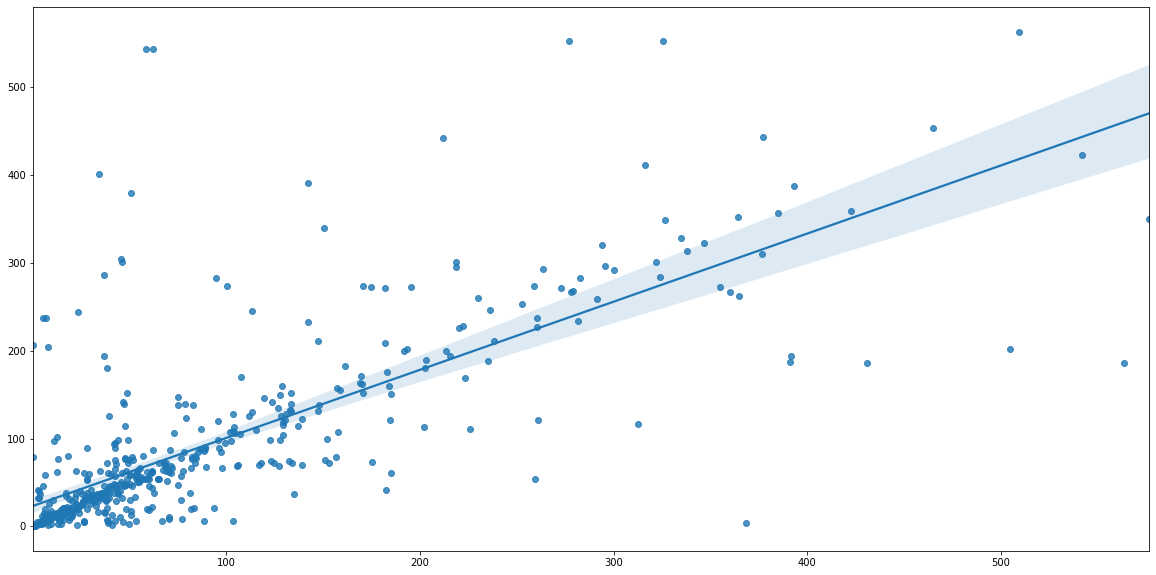

In [238]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox_star,prediction_invboxcox_star)